In [370]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU, BatchNormalization, LeakyReLU
from keras.losses import mse
from keras.constraints import non_neg

In [371]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [372]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [373]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=800,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [374]:
runs = [304125,304508,302263]

with open('pileupInput_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
with open('pileupInput_bad.pickle', 'rb') as handle:
    bad_data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

x_bad1 = np.array(bad_data['301480']['samples'])
x_bad2 = np.array(bad_data['305588']['samples'])



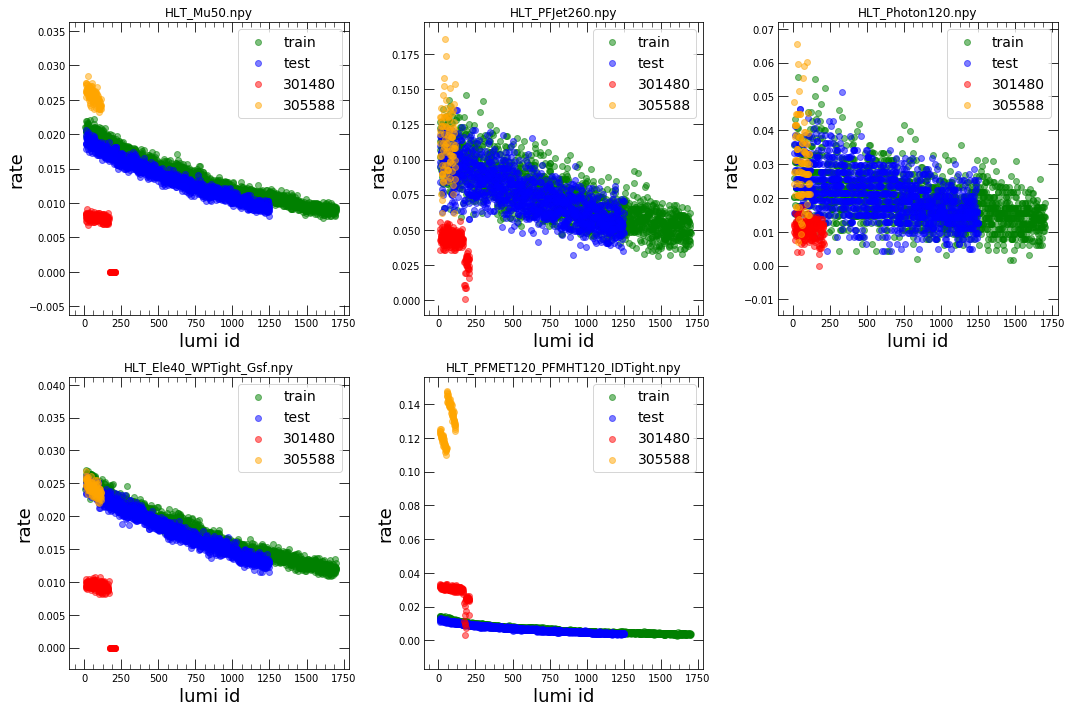

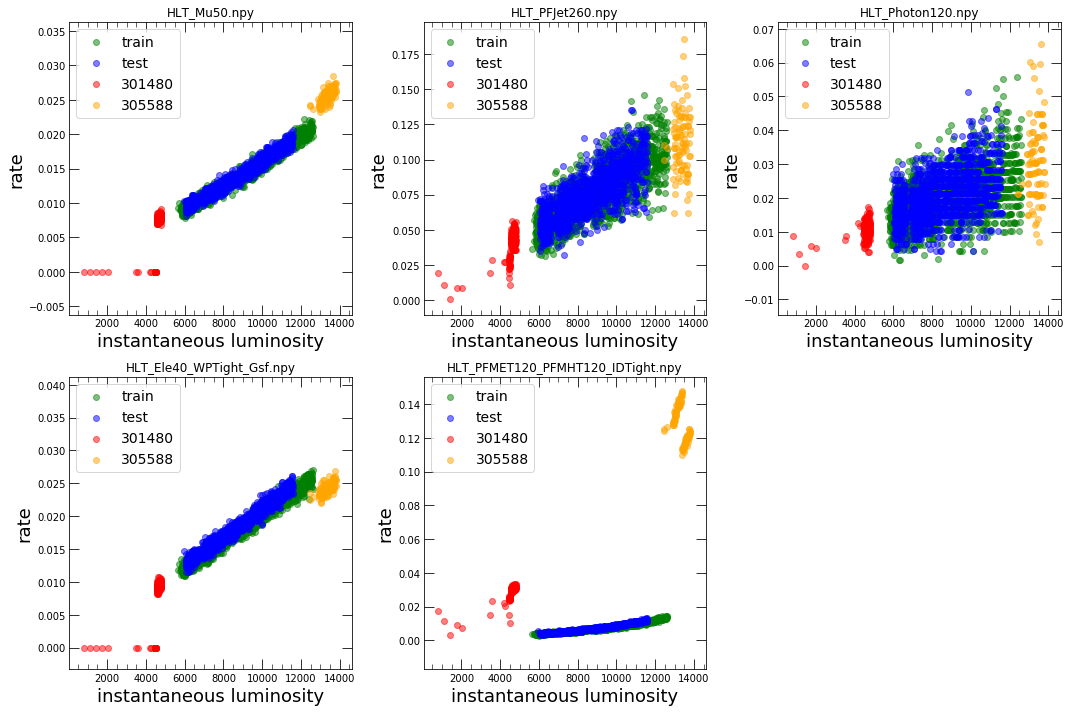

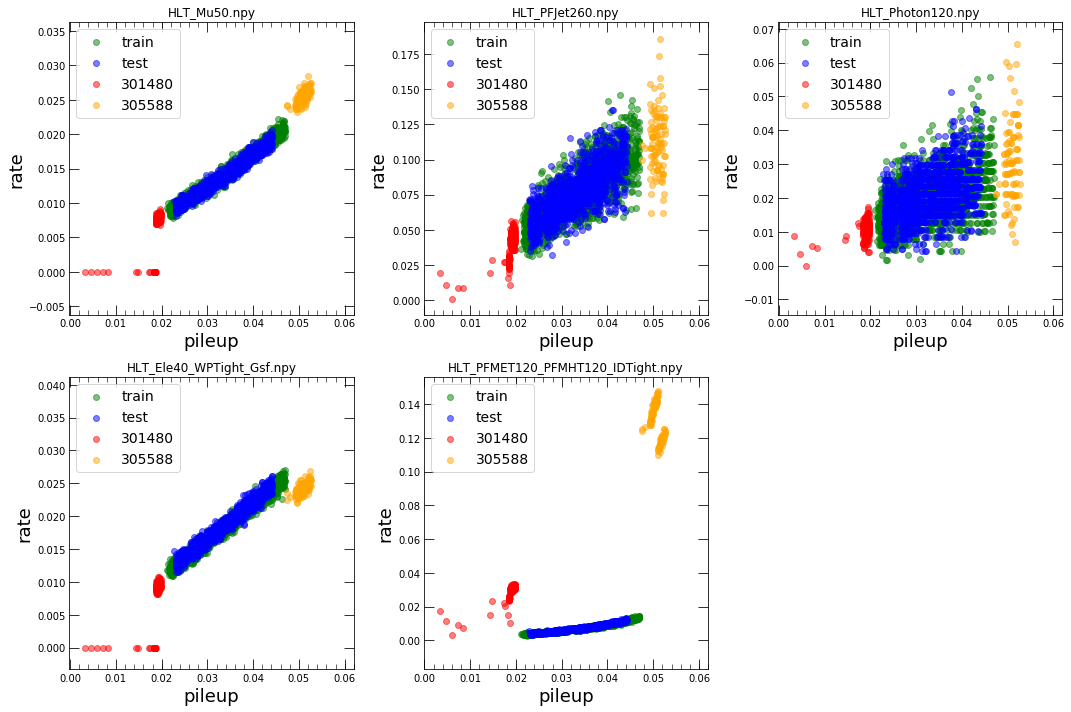

In [375]:
plots = [x_train,x_test,x_bad1,x_bad2]
titles = ["train","test","301480","305588"]

stuff = [[],[],[],[]]
lumi = [[],[],[],[]]
inst = [[],[],[],[]]
pileup = [[],[],[],[]]
for h in range(4):
    if h == 0 or h == 1:
        lumi[h] = data[str(runs[h])]['lumiid']
        inst[h] = data[str(runs[h])]['instlumi']
        pileup[h] = data[str(runs[h])]['pileup']
        stuff[h] = data[str(runs[h])]['rates']
    elif h == 2:
        lumi[h] = bad_data["301480"]['lumiid']
        inst[h] = bad_data["301480"]['instlumi']
        pileup[h] = bad_data["301480"]['pileup']
        stuff[h] = bad_data["301480"]['rates']
    else:
        lumi[h] = bad_data["305588"]['lumiid']
        inst[h] = bad_data["305588"]['instlumi']
        pileup[h] = bad_data["305588"]['pileup']
        stuff[h] = bad_data["305588"]['rates']
    
labels = data['HLT'] 
colors = ["g","b","r","orange"]
    
plt.figure(figsize=[15,10])
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(i[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(inst[k][i]),len(stuff[k][i]))
        plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('instantaneous luminosity')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Simple Autoencoder

In [376]:
model_name = "pileupInputPReLU"

In [377]:
# Define the architecture

_input = Input(shape=(6,), name="input")

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               name="encoded")(_input)

active = PReLU()(hidden)

output = Dense(6,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(active)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
encoded (Dense)              (None, 3)                 21        
_________________________________________________________________
p_re_lu_4 (PReLU)            (None, 3)                 3         
_________________________________________________________________
reconstructed (Dense)        (None, 6)                 24        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


Train on 1669 samples, validate on 1224 samples
Epoch 1/800
 - 7s - loss: 0.2244 - val_loss: 0.2237
Epoch 2/800
 - 0s - loss: 0.2188 - val_loss: 0.2182
Epoch 3/800
 - 0s - loss: 0.2134 - val_loss: 0.2127
Epoch 4/800
 - 0s - loss: 0.2080 - val_loss: 0.2073
Epoch 5/800
 - 0s - loss: 0.2028 - val_loss: 0.2020
Epoch 6/800
 - 0s - loss: 0.1976 - val_loss: 0.1969
Epoch 7/800
 - 0s - loss: 0.1925 - val_loss: 0.1918
Epoch 8/800
 - 0s - loss: 0.1875 - val_loss: 0.1868
Epoch 9/800
 - 0s - loss: 0.1827 - val_loss: 0.1820
Epoch 10/800
 - 0s - loss: 0.1780 - val_loss: 0.1773
Epoch 11/800
 - 0s - loss: 0.1733 - val_loss: 0.1727
Epoch 12/800
 - 0s - loss: 0.1688 - val_loss: 0.1682
Epoch 13/800
 - 0s - loss: 0.1644 - val_loss: 0.1638
Epoch 14/800
 - 0s - loss: 0.1601 - val_loss: 0.1595
Epoch 15/800
 - 0s - loss: 0.1560 - val_loss: 0.1554
Epoch 16/800
 - 0s - loss: 0.1519 - val_loss: 0.1514
Epoch 17/800
 - 0s - loss: 0.1480 - val_loss: 0.1475
Epoch 18/800
 - 0s - loss: 0.1442 - val_loss: 0.1436
Epoch 1

Epoch 154/800
 - 0s - loss: 0.0092 - val_loss: 0.0092
Epoch 155/800
 - 0s - loss: 0.0090 - val_loss: 0.0091
Epoch 156/800
 - 0s - loss: 0.0089 - val_loss: 0.0089
Epoch 157/800
 - 0s - loss: 0.0088 - val_loss: 0.0088
Epoch 158/800
 - 0s - loss: 0.0086 - val_loss: 0.0087
Epoch 159/800
 - 0s - loss: 0.0085 - val_loss: 0.0085
Epoch 160/800
 - 0s - loss: 0.0084 - val_loss: 0.0084
Epoch 161/800
 - 0s - loss: 0.0082 - val_loss: 0.0083
Epoch 162/800
 - 0s - loss: 0.0081 - val_loss: 0.0082
Epoch 163/800
 - 0s - loss: 0.0080 - val_loss: 0.0080
Epoch 164/800
 - 0s - loss: 0.0079 - val_loss: 0.0079
Epoch 165/800
 - 0s - loss: 0.0078 - val_loss: 0.0078
Epoch 166/800
 - 0s - loss: 0.0076 - val_loss: 0.0077
Epoch 167/800
 - 0s - loss: 0.0075 - val_loss: 0.0076
Epoch 168/800
 - 0s - loss: 0.0074 - val_loss: 0.0075
Epoch 169/800
 - 0s - loss: 0.0073 - val_loss: 0.0073
Epoch 170/800
 - 0s - loss: 0.0072 - val_loss: 0.0072
Epoch 171/800
 - 0s - loss: 0.0071 - val_loss: 0.0071
Epoch 172/800
 - 0s - loss: 

Epoch 306/800
 - 0s - loss: 0.0014 - val_loss: 0.0014
Epoch 307/800
 - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 308/800
 - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 309/800
 - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 310/800
 - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 311/800
 - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 312/800
 - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 313/800
 - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 314/800
 - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 315/800
 - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 316/800
 - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 317/800
 - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 318/800
 - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 319/800
 - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 320/800
 - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 321/800
 - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 322/800
 - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 323/800
 - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 324/800
 - 0s - loss: 

 - 0s - loss: 3.9522e-04 - val_loss: 3.9577e-04
Epoch 443/800
 - 0s - loss: 3.9199e-04 - val_loss: 3.9253e-04
Epoch 444/800
 - 0s - loss: 3.8880e-04 - val_loss: 3.8932e-04
Epoch 445/800
 - 0s - loss: 3.8563e-04 - val_loss: 3.8615e-04
Epoch 446/800
 - 0s - loss: 3.8252e-04 - val_loss: 3.8299e-04
Epoch 447/800
 - 0s - loss: 3.7943e-04 - val_loss: 3.7987e-04
Epoch 448/800
 - 0s - loss: 3.7634e-04 - val_loss: 3.7678e-04
Epoch 449/800
 - 0s - loss: 3.7329e-04 - val_loss: 3.7371e-04
Epoch 450/800
 - 0s - loss: 3.7028e-04 - val_loss: 3.7068e-04
Epoch 451/800
 - 0s - loss: 3.6729e-04 - val_loss: 3.6767e-04
Epoch 452/800
 - 0s - loss: 3.6434e-04 - val_loss: 3.6469e-04
Epoch 453/800
 - 0s - loss: 3.6138e-04 - val_loss: 3.6174e-04
Epoch 454/800
 - 0s - loss: 3.5851e-04 - val_loss: 3.5881e-04
Epoch 455/800
 - 0s - loss: 3.5562e-04 - val_loss: 3.5591e-04
Epoch 456/800
 - 0s - loss: 3.5277e-04 - val_loss: 3.5304e-04
Epoch 457/800
 - 0s - loss: 3.4995e-04 - val_loss: 3.5020e-04
Epoch 458/800
 - 0s - 

Epoch 575/800
 - 0s - loss: 1.4546e-04 - val_loss: 1.4432e-04
Epoch 576/800
 - 0s - loss: 1.4448e-04 - val_loss: 1.4332e-04
Epoch 577/800
 - 0s - loss: 1.4349e-04 - val_loss: 1.4233e-04
Epoch 578/800
 - 0s - loss: 1.4252e-04 - val_loss: 1.4135e-04
Epoch 579/800
 - 0s - loss: 1.4155e-04 - val_loss: 1.4038e-04
Epoch 580/800
 - 0s - loss: 1.4059e-04 - val_loss: 1.3942e-04
Epoch 581/800
 - 0s - loss: 1.3965e-04 - val_loss: 1.3846e-04
Epoch 582/800
 - 0s - loss: 1.3870e-04 - val_loss: 1.3751e-04
Epoch 583/800
 - 0s - loss: 1.3776e-04 - val_loss: 1.3657e-04
Epoch 584/800
 - 0s - loss: 1.3684e-04 - val_loss: 1.3564e-04
Epoch 585/800
 - 0s - loss: 1.3592e-04 - val_loss: 1.3471e-04
Epoch 586/800
 - 0s - loss: 1.3501e-04 - val_loss: 1.3379e-04
Epoch 587/800
 - 0s - loss: 1.3410e-04 - val_loss: 1.3288e-04
Epoch 588/800
 - 0s - loss: 1.3321e-04 - val_loss: 1.3198e-04
Epoch 589/800
 - 0s - loss: 1.3232e-04 - val_loss: 1.3109e-04
Epoch 590/800
 - 0s - loss: 1.3143e-04 - val_loss: 1.3020e-04
Epoch 59

 - 0s - loss: 6.5142e-05 - val_loss: 6.3537e-05
Epoch 708/800
 - 0s - loss: 6.4802e-05 - val_loss: 6.3194e-05
Epoch 709/800
 - 0s - loss: 6.4463e-05 - val_loss: 6.2853e-05
Epoch 710/800
 - 0s - loss: 6.4126e-05 - val_loss: 6.2515e-05
Epoch 711/800
 - 0s - loss: 6.3793e-05 - val_loss: 6.2180e-05
Epoch 712/800
 - 0s - loss: 6.3459e-05 - val_loss: 6.1847e-05
Epoch 713/800
 - 0s - loss: 6.3132e-05 - val_loss: 6.1517e-05
Epoch 714/800
 - 0s - loss: 6.2803e-05 - val_loss: 6.1190e-05
Epoch 715/800
 - 0s - loss: 6.2481e-05 - val_loss: 6.0864e-05
Epoch 716/800
 - 0s - loss: 6.2159e-05 - val_loss: 6.0541e-05
Epoch 717/800
 - 0s - loss: 6.1841e-05 - val_loss: 6.0221e-05
Epoch 718/800
 - 0s - loss: 6.1524e-05 - val_loss: 5.9903e-05
Epoch 719/800
 - 0s - loss: 6.1209e-05 - val_loss: 5.9588e-05
Epoch 720/800
 - 0s - loss: 6.0897e-05 - val_loss: 5.9275e-05
Epoch 721/800
 - 0s - loss: 6.0588e-05 - val_loss: 5.8965e-05
Epoch 722/800
 - 0s - loss: 6.0283e-05 - val_loss: 5.8656e-05
Epoch 723/800
 - 0s - 

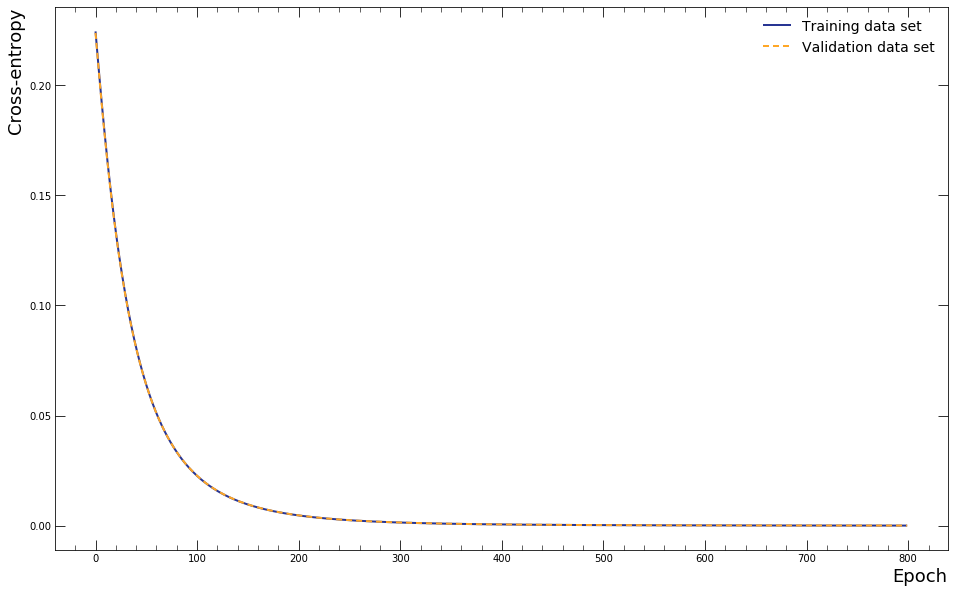

In [378]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

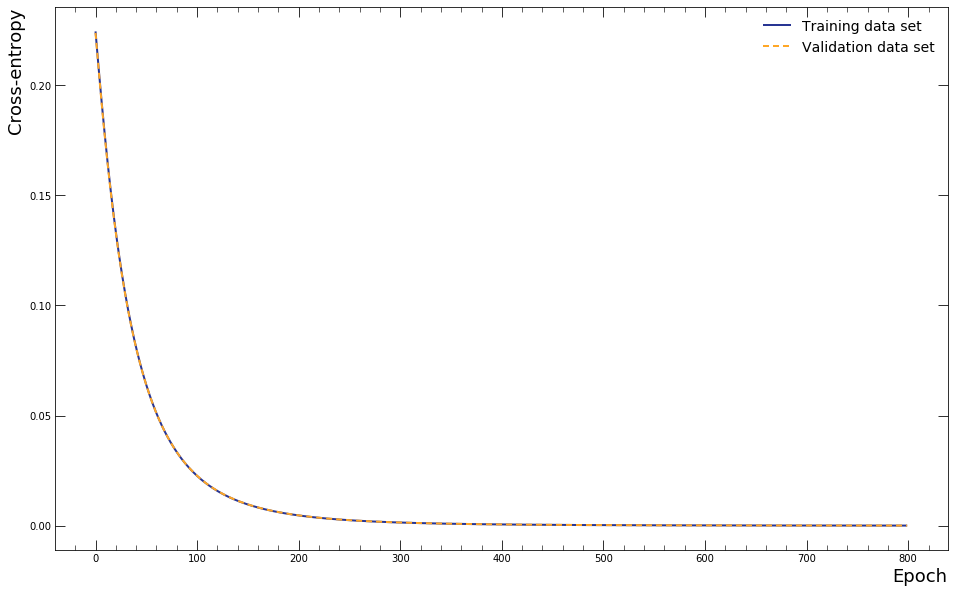

In [379]:
plot_loss(history)

## Training Set

In [380]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_train_new = []
lumi_new = []
lumi = data[str(runs[0])]['lumiid'] 
                
reconstructed = model.predict(np.array(x_train))

error_train = abs(x_train-reconstructed)/x_train

In [381]:
error_reformat = []
inp = []
outp = []
for i in range(6):
    error_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error_train)):
    for j in range(6):
        error_reformat[j].append(error_train[i][j])
        outp[j].append(reconstructed[i][j])
        inp[j].append(x_train[i][j])

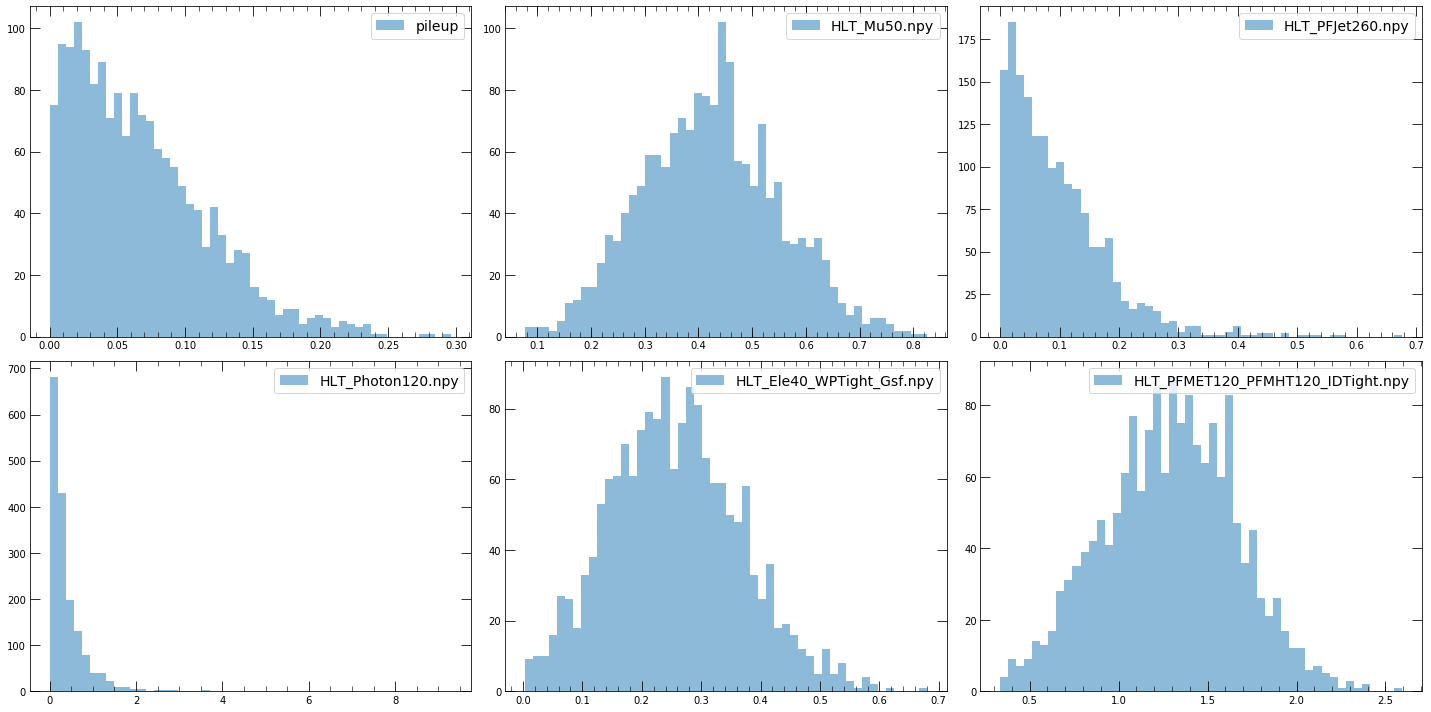

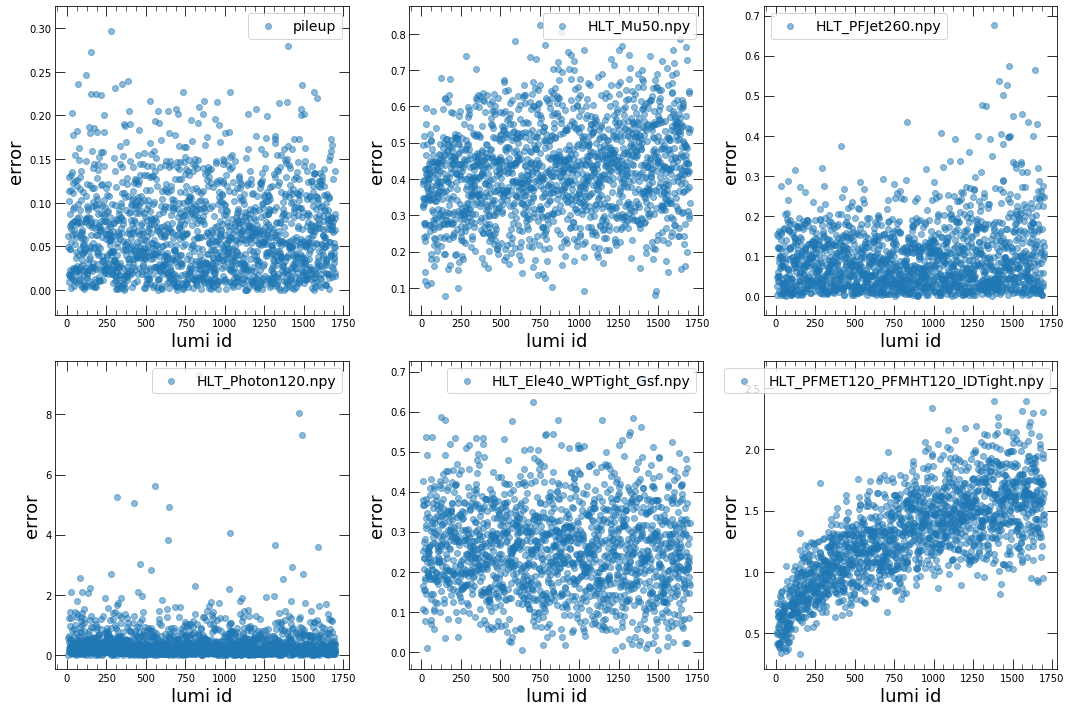

In [382]:
labels = ['pileup'] + data['HLT']
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
plt.tight_layout()

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
plt.tight_layout()
plt.show()

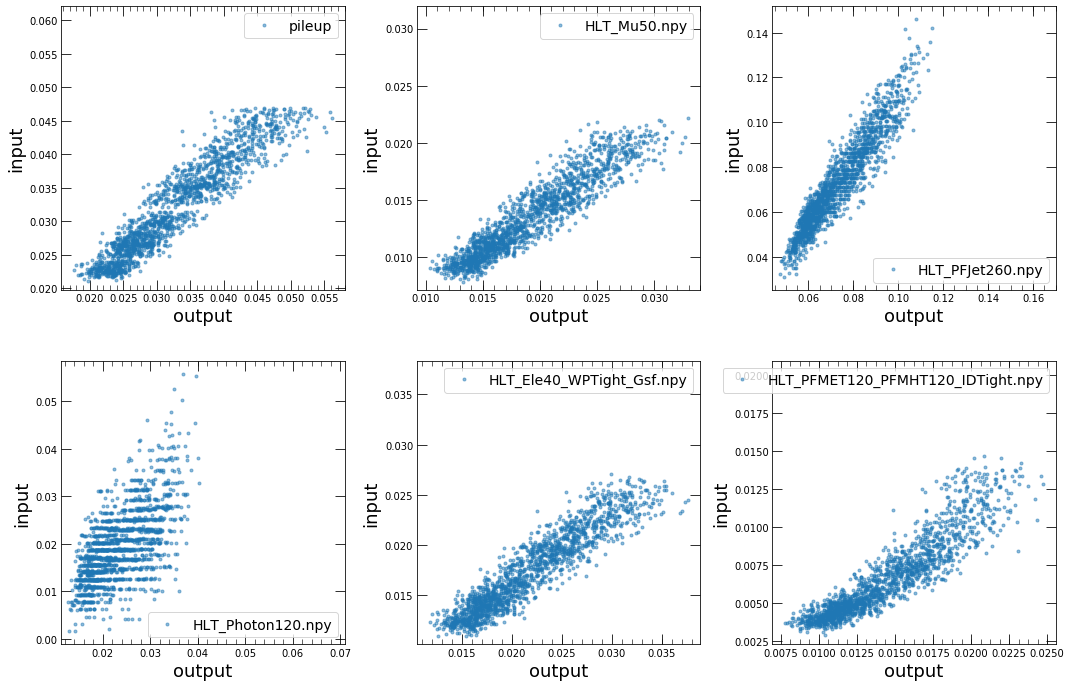

In [383]:
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend() 
    
    plt.axis('square')

plt.tight_layout()
plt.show()

In [384]:
# Generate predictions

model = load_model("%s.h5" % (model_name))   
reconstructed = model.predict(np.array(x_train))

means = []
error_train= []
for s in range(len(x_train)):
    mean = np.mean(x_train[s])
    means.append(mean)
    
    mse = 0
    for r in range(len(reconstructed[s])):
        mse += (reconstructed[s][r]-mean)**2
        
    mse = mse/len(reconstructed[s])
    error_train.append(mse)
    
lumi_train = data[str(runs[0])]['lumiid'] 

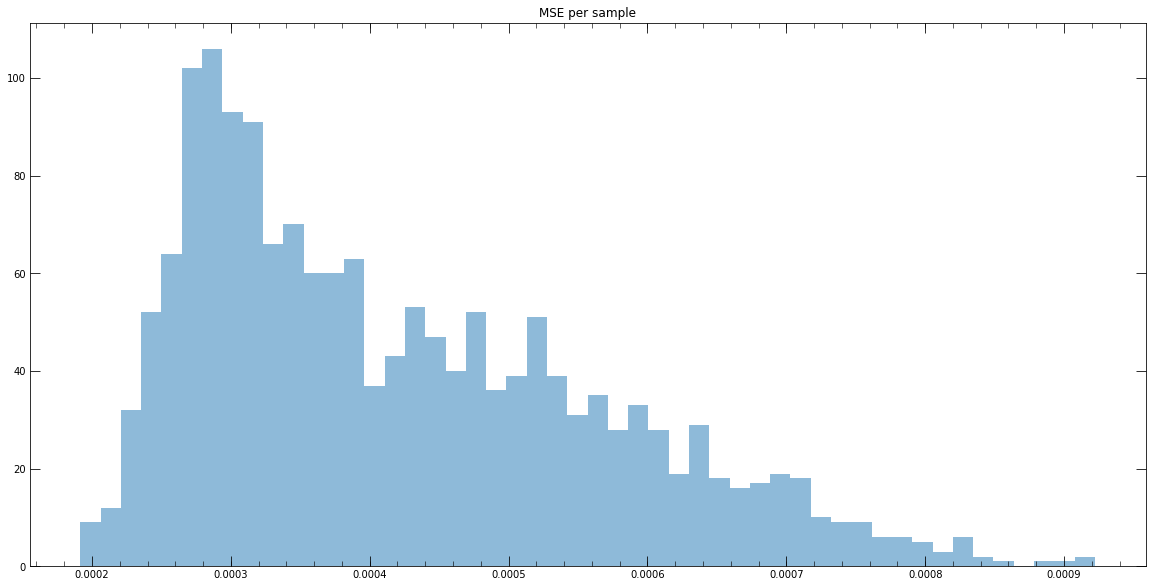

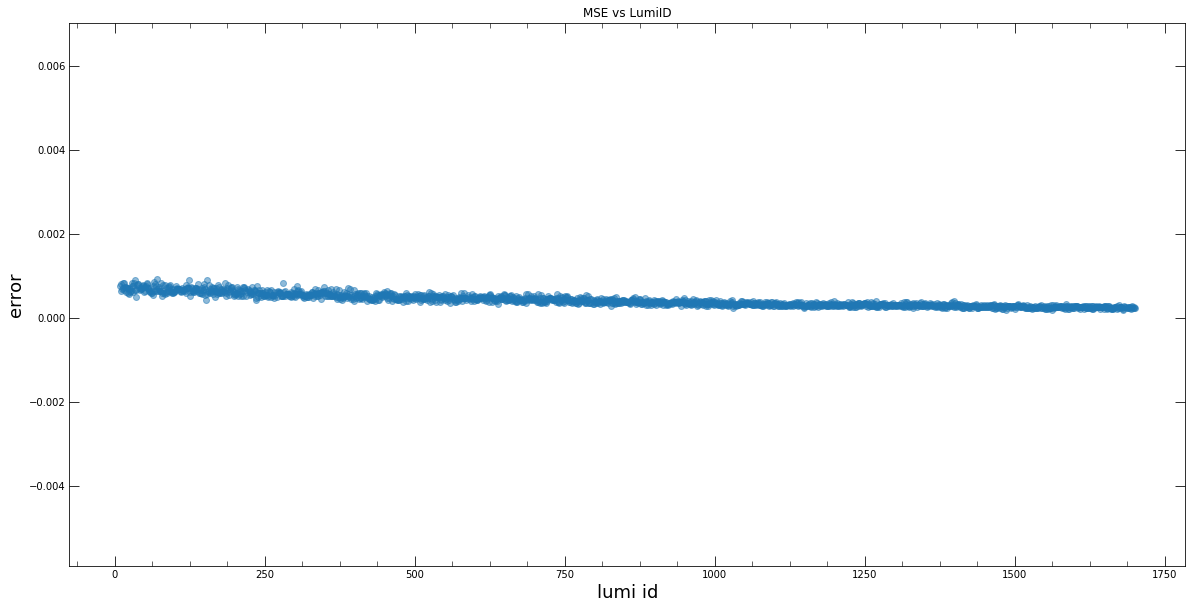

In [385]:
bins = 50
plt.figure(figsize=[20,10])
plt.hist(error_train,bins=bins,alpha=.5)
plt.title('MSE per sample')

plt.figure(figsize=[20,10])
plt.scatter(lumi_train,error_train,alpha=.5)
plt.xlabel('lumi id')
plt.ylabel('error')
plt.title('MSE vs LumiID')    

plt.show()

## Test Data

In [386]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [387]:
error_reformat = []
inp = []
outp = []
for i in range(6):
    error_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    #print(len(error_reformat[0]))
    for j in range(6):
        error_reformat[j].append(error[i][j])
        outp[j].append(reconstructed[i][j])
        inp[j].append(x_test_new[i][j])

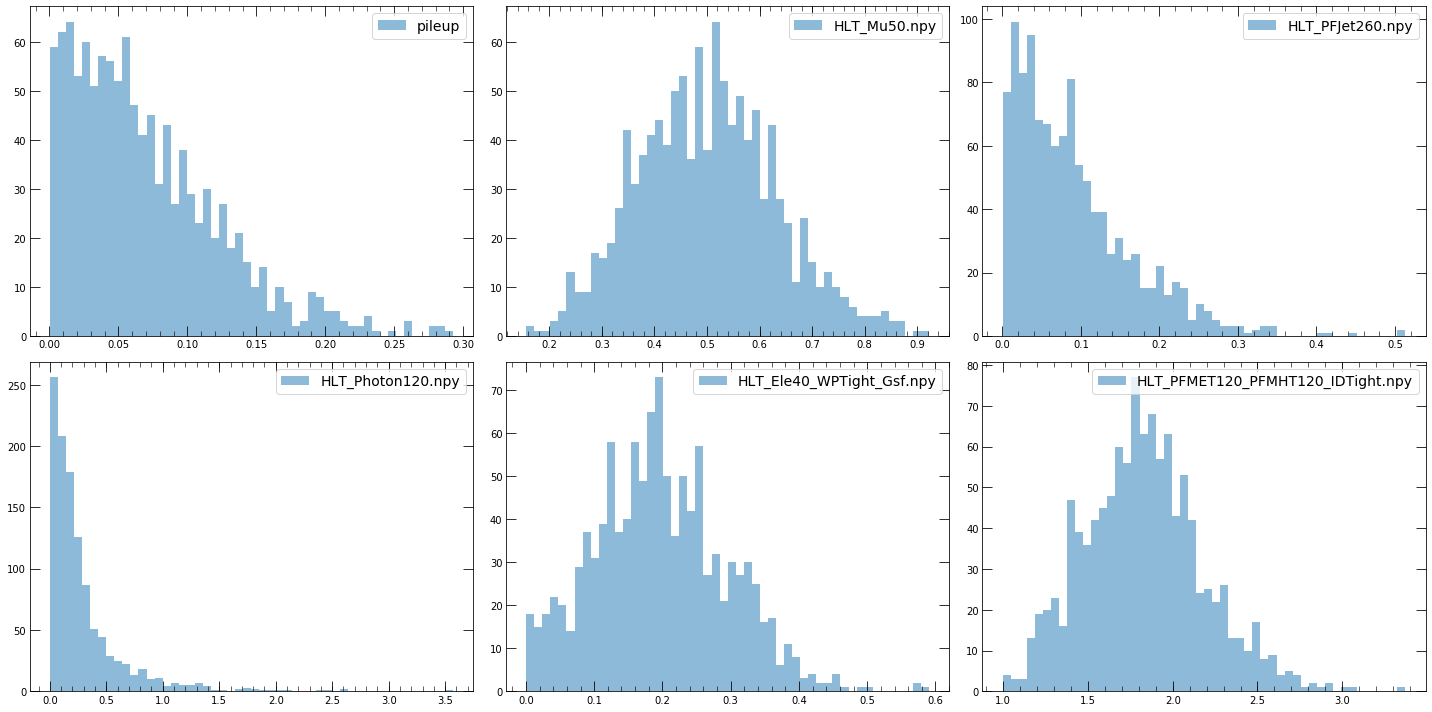

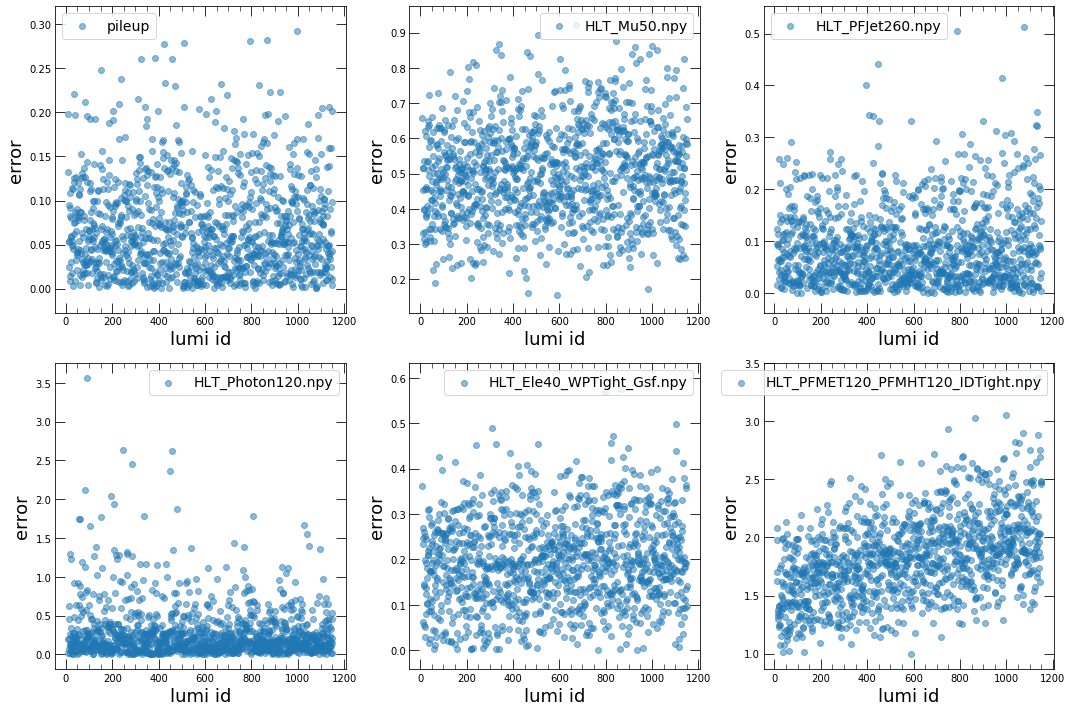

In [388]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.tight_layout()
plt.show()

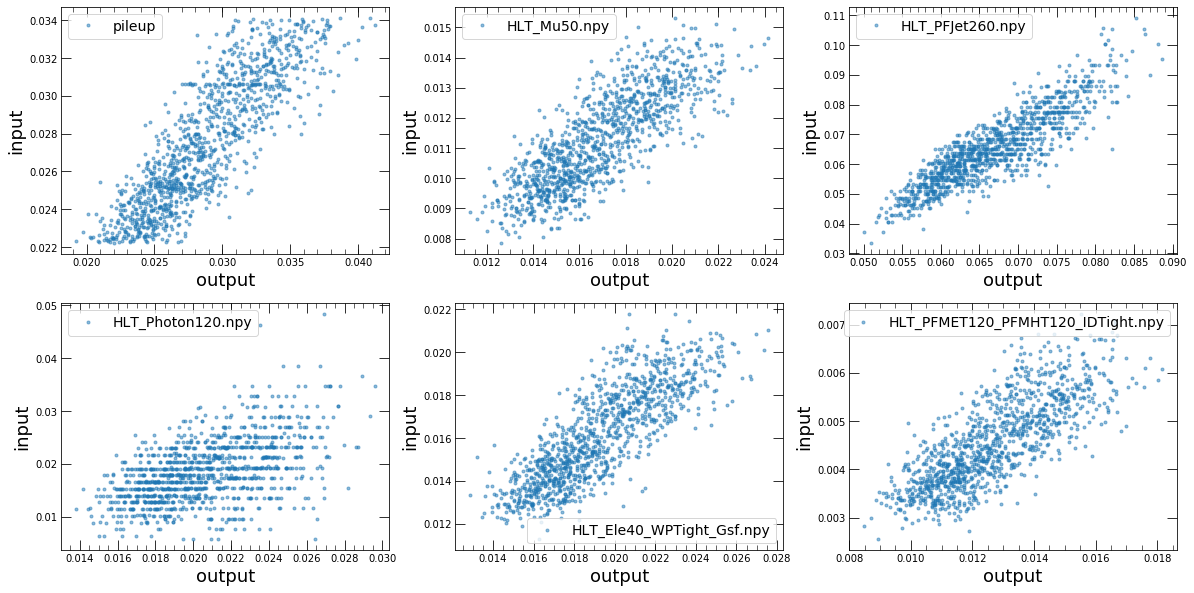

In [389]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

In [390]:
# plt.figure(figsize=[15,10])
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [391]:
# Generate predictions

model = load_model("%s.h5" % (model_name))   
reconstructed = model.predict(np.array(x_test))

means = []
error = []
for s in range(len(x_test)):
    mean = np.mean(x_test[s])
    means.append(mean)
    
    mse = 0
    for r in range(len(reconstructed[s])):
        mse += (reconstructed[s][r]-mean)**2
        
    mse = mse/len(reconstructed[s])
    error.append(mse)
    
lumi = data[str(runs[2])]['lumiid'] 

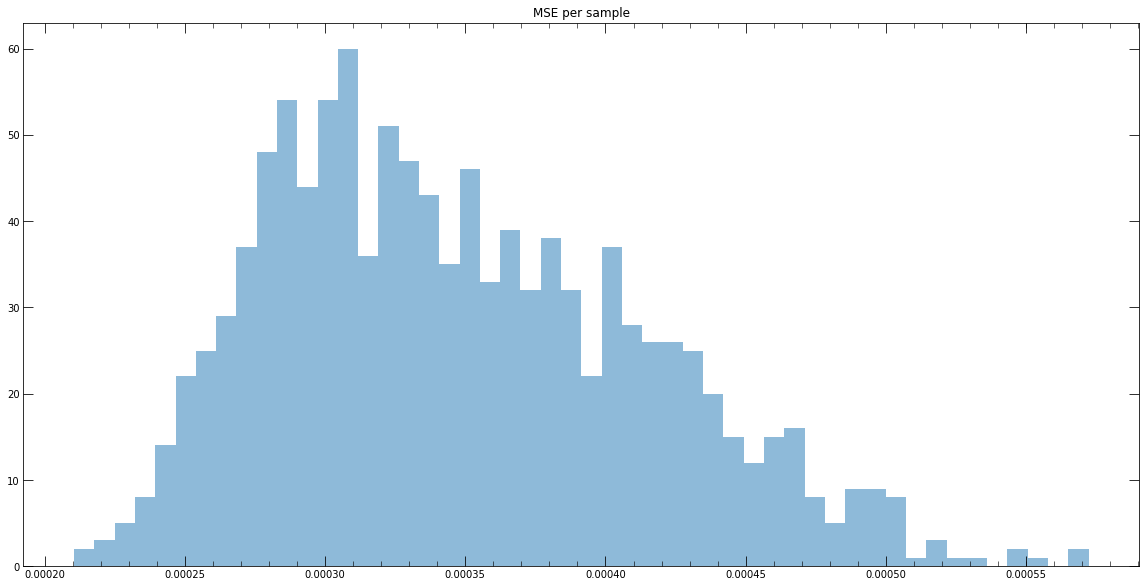

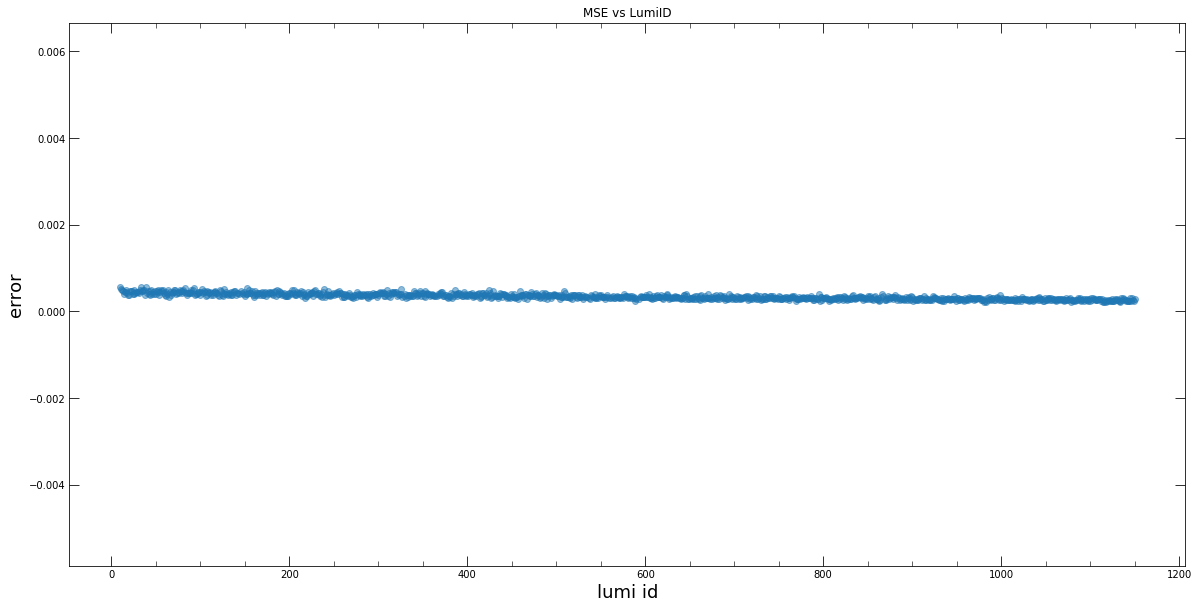

In [392]:
bins = 50
plt.figure(figsize=[20,10])
plt.hist(error,bins=bins,alpha=.5)
plt.title('MSE per sample')

plt.figure(figsize=[20,10])
plt.scatter(lumi,error,alpha=.5)
plt.xlabel('lumi id')
plt.ylabel('error')
plt.title('MSE vs LumiID')    

plt.show()

In [393]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [394]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [395]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [396]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])
            
        

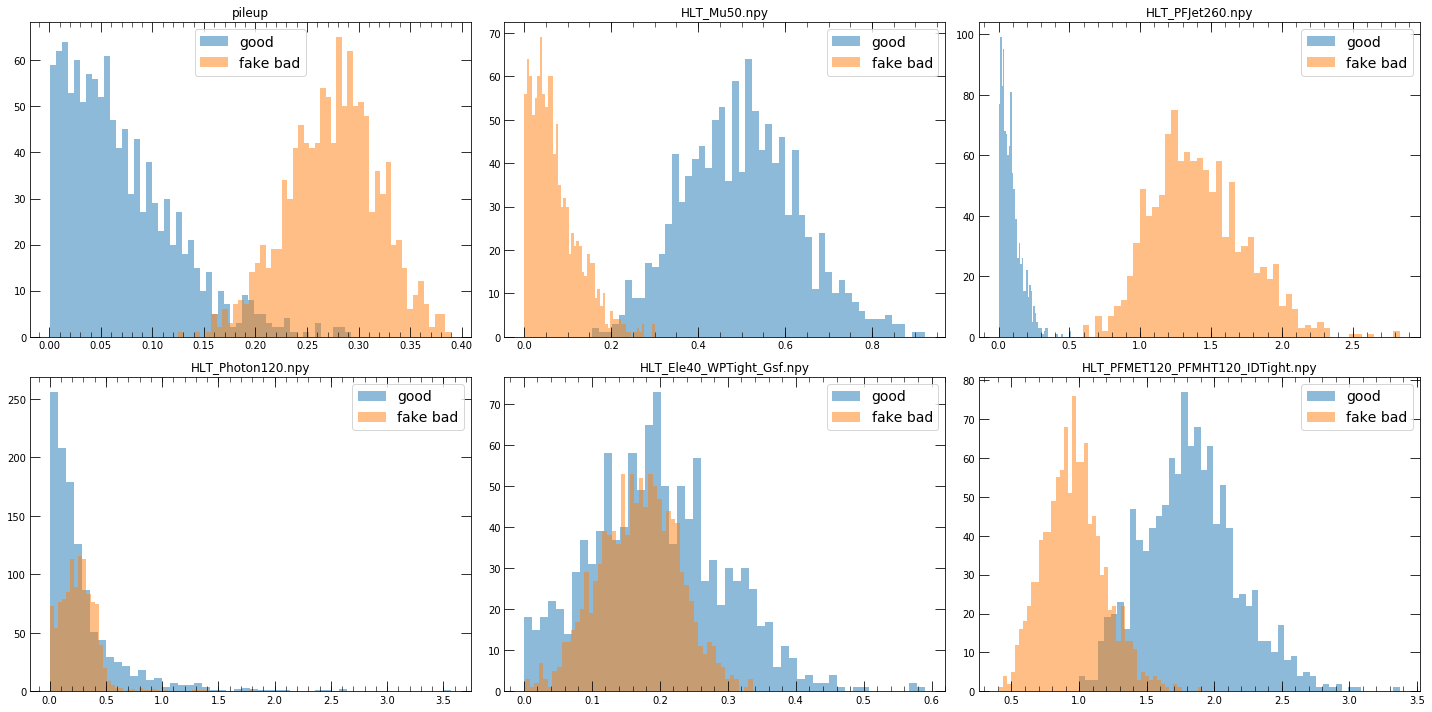

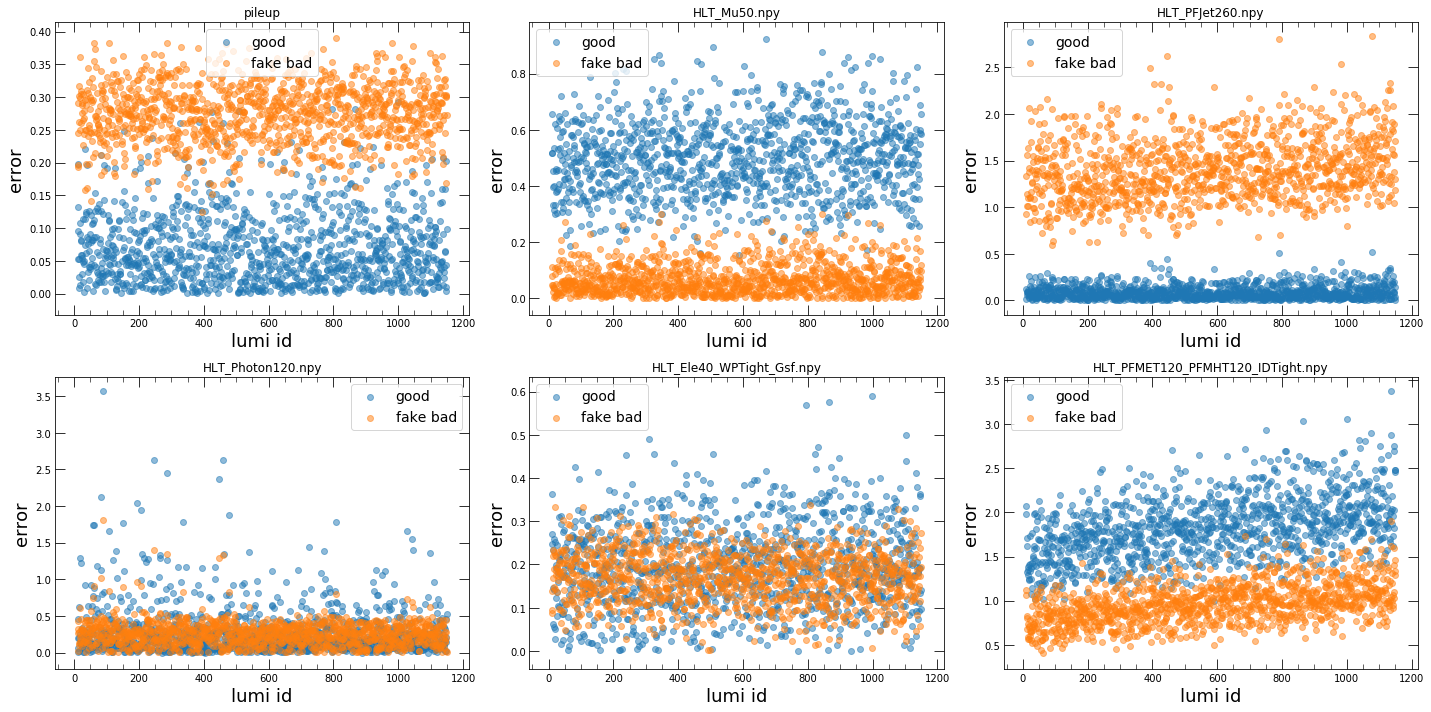

In [397]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi = data[str(runs[2])]['lumiid'] 
#print(len(error_reformat_bad[0]),len(error_reformat[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

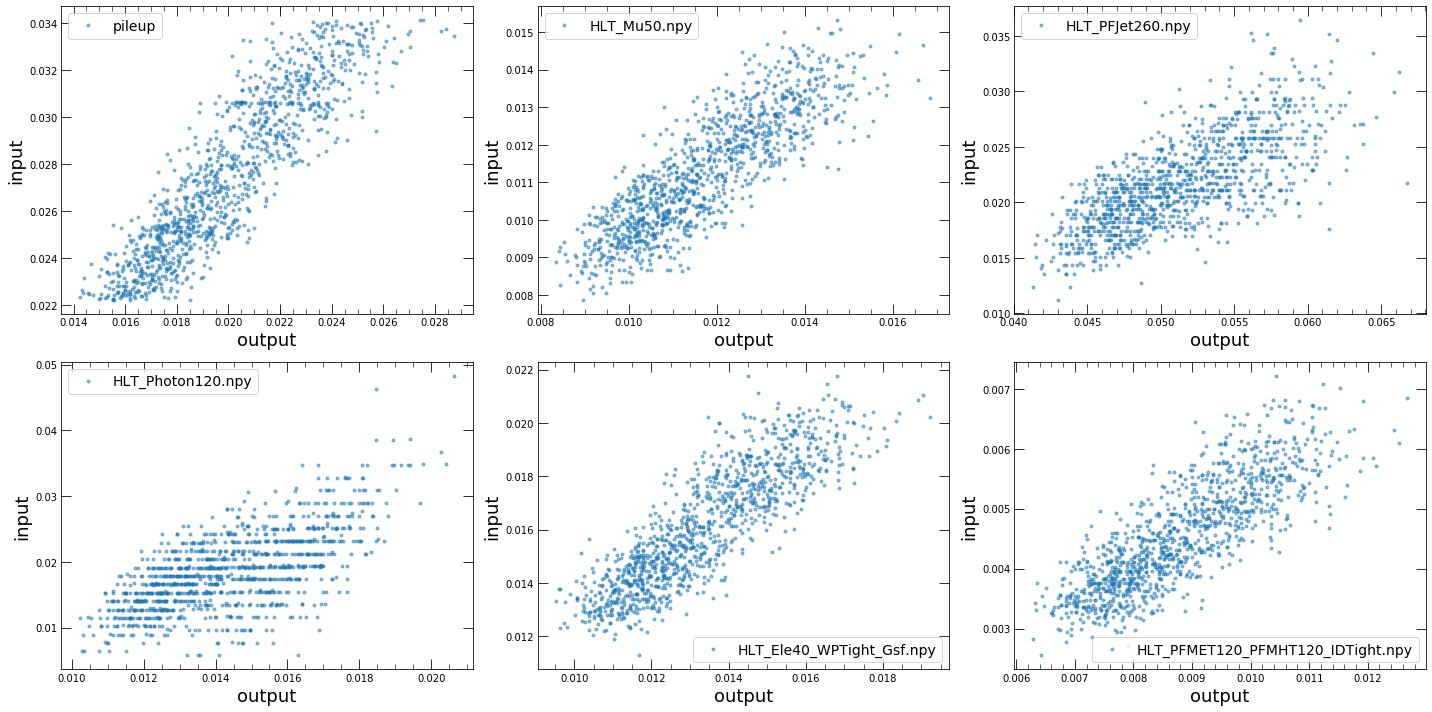

In [398]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()    
plt.tight_layout()
plt.show()

In [399]:
# Generate predictions

model = load_model("%s.h5" % (model_name))   
reconstructed = model.predict(np.array(bad_new))

means_bad = []
error_bad = []
for s in range(len(bad_new)):
    mean = np.mean(bad_new[s])
    means_bad.append(mean)
    
    mse = 0
    for r in range(len(reconstructed[s])):
        mse += (reconstructed[s][r]-mean)**2
        
    mse = mse/len(reconstructed[s])
    error_bad.append(mse)

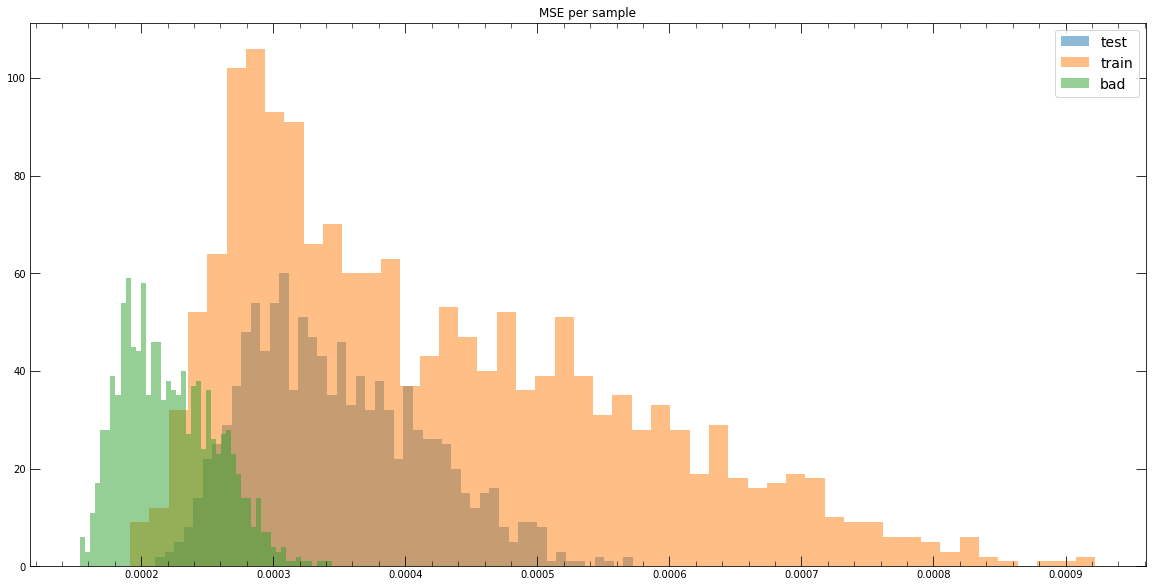

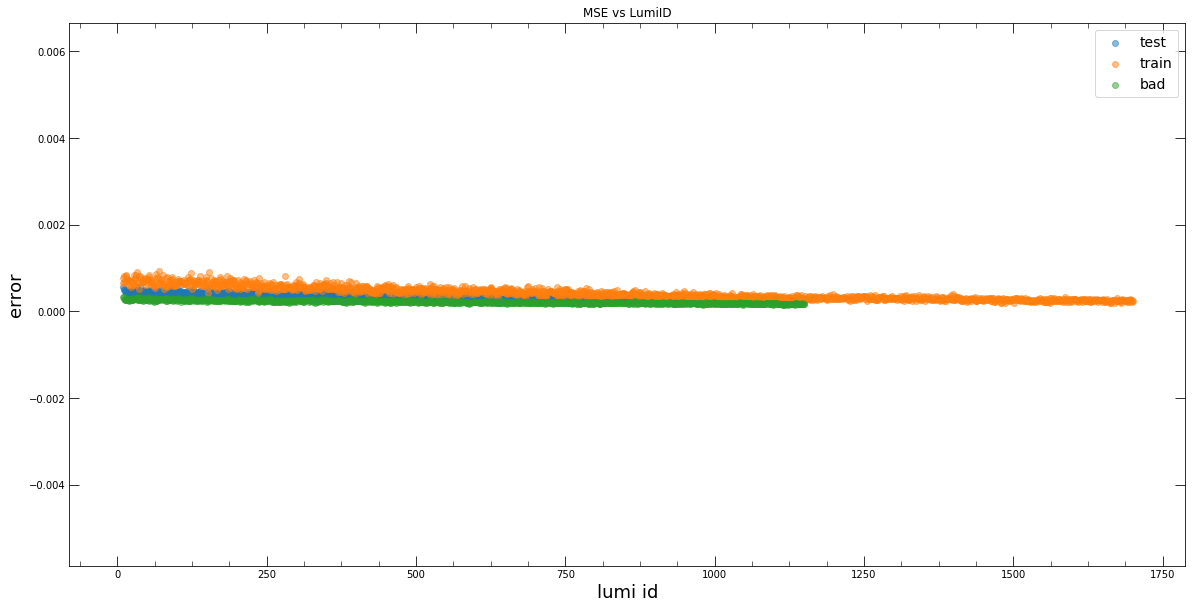

In [400]:

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
plt.hist(error,bins=bins,label='test',alpha=.5)
plt.hist(error_train,bins=bins,label='train',alpha=.5)
plt.hist(error_bad,bins=bins,label='bad',alpha=.5)
plt.title('MSE per sample')
plt.legend()

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
plt.scatter(lumi,error,label='test',alpha=.5)
plt.scatter(lumi_train,error_train,label='train',alpha=.5)
plt.scatter(lumi,error_bad,label='bad',alpha=.5)
plt.xlabel('lumi id')
plt.ylabel('error')
plt.title('MSE vs LumiID')  
plt.legend()

plt.show()

## Fake Bad Data - ALL

In [401]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [402]:
reconstructed_bad = model.predict(np.array(bad))

error_bad = abs(bad-reconstructed_bad)/bad

In [403]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad[i][j])

1129 1129


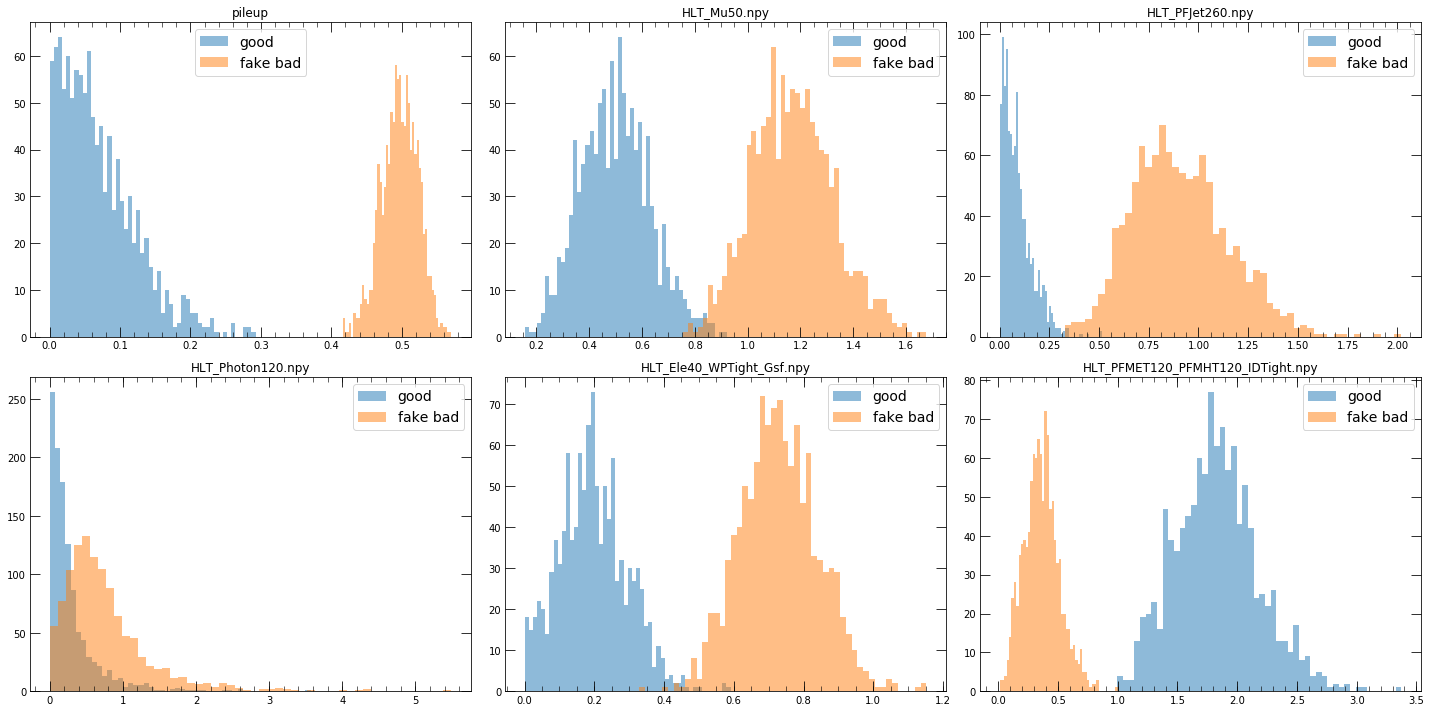

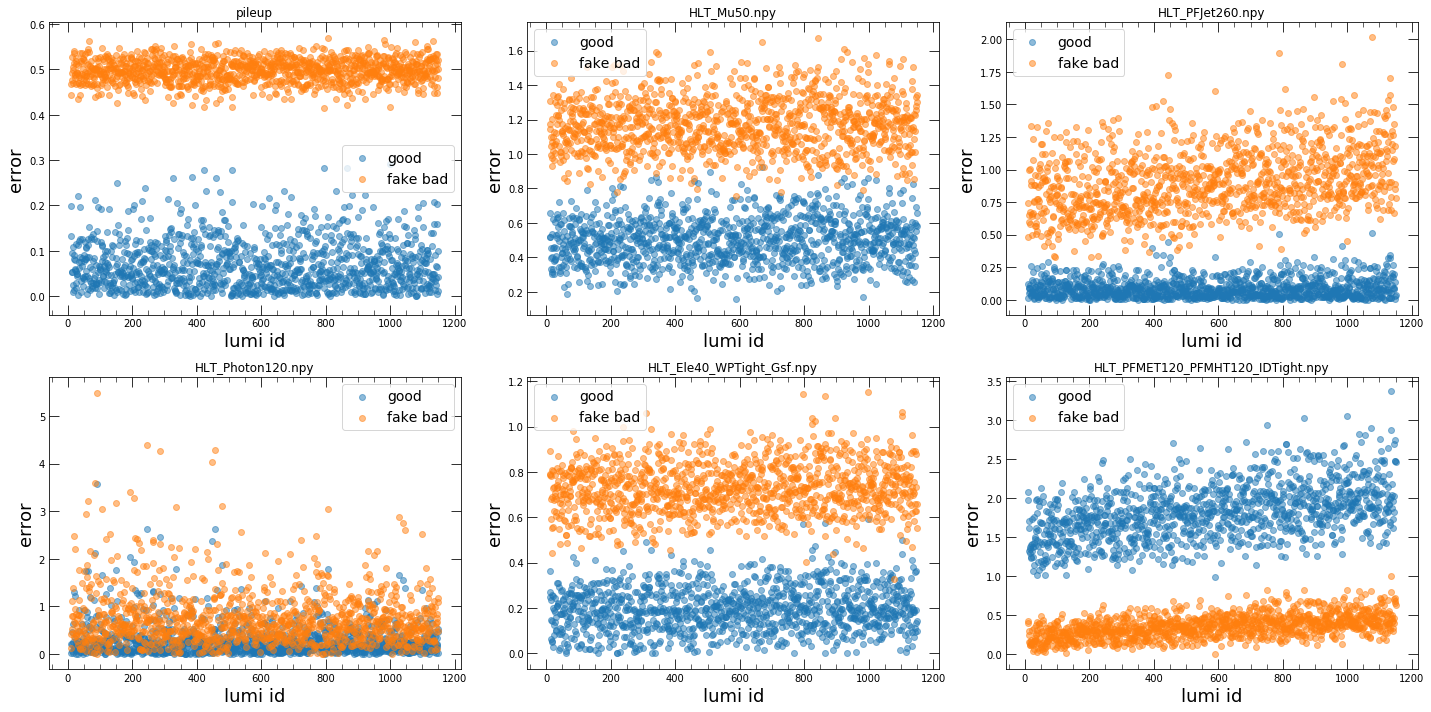

In [404]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
    
plt.show()

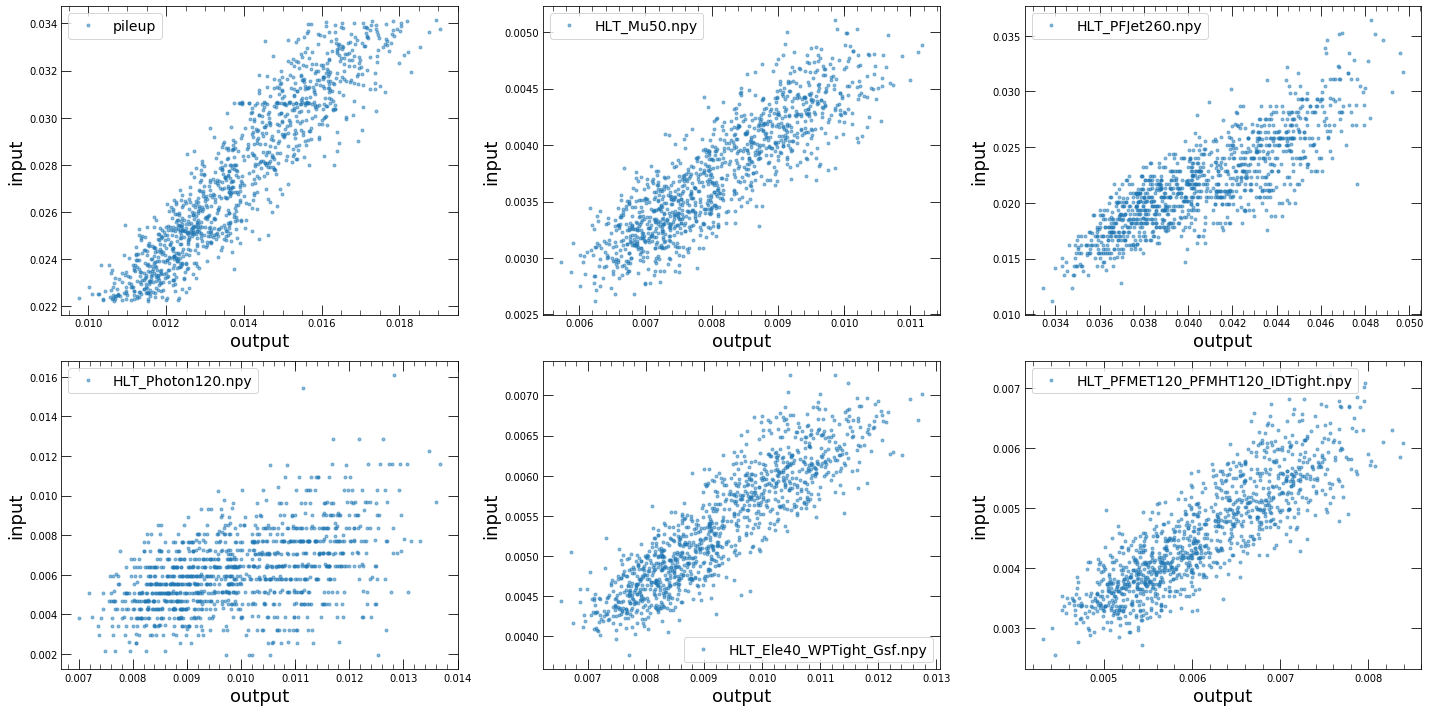

In [405]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.tight_layout()
    
plt.show()

In [406]:
# Generate predictions

model = load_model("%s.h5" % (model_name))   
reconstructed = model.predict(np.array(bad))

means_bad = []
error_bad = []
for s in range(len(bad)):
    mean = np.mean(bad[s])
    means_bad.append(mean)
    
    mse = 0
    for r in range(len(reconstructed[s])):
        mse += (reconstructed[s][r]-mean)**2
        
    mse = mse/len(reconstructed[s])
    error_bad.append(mse)

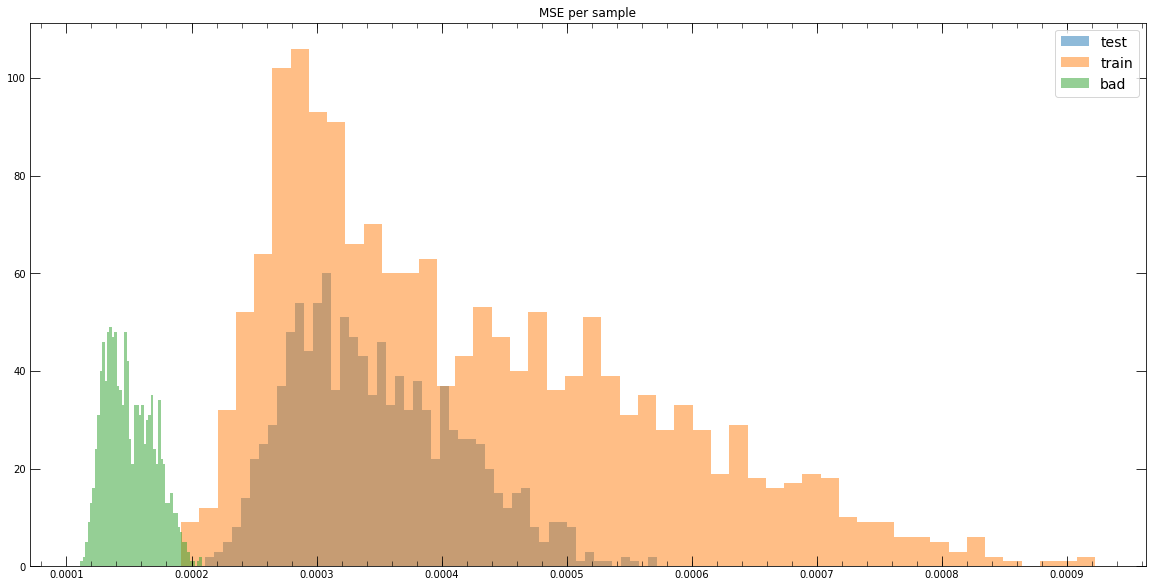

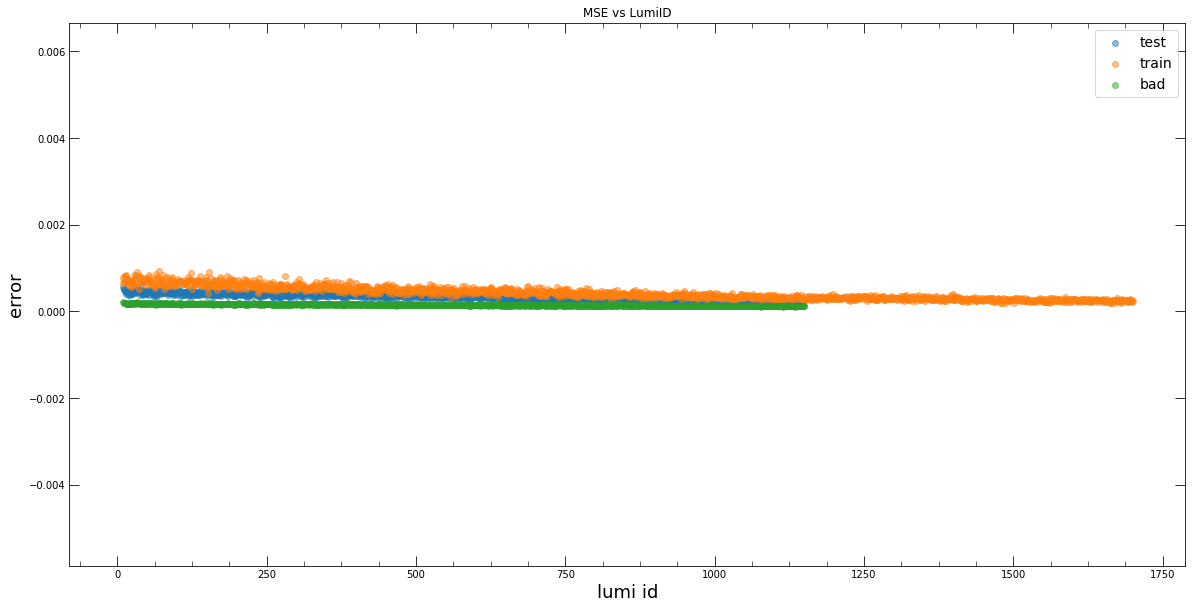

In [407]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
plt.hist(error,bins=bins,label='test',alpha=.5)
plt.hist(error_train,bins=bins,label='train',alpha=.5)
plt.hist(error_bad,bins=bins,label='bad',alpha=.5)
plt.title('MSE per sample')
plt.legend()
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
plt.scatter(lumi,error,label='test',alpha=.5)
plt.scatter(lumi_train,error_train,label='train',alpha=.5)
plt.scatter(lumi,error_bad,label='bad',alpha=.5)
plt.xlabel('lumi id')
plt.ylabel('error')
plt.title('MSE vs LumiID')    
plt.legend()
plt.show()

## Real Bad Data

In [408]:
bad_runs = [301480]

with open('pileupInput_bad.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [409]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        lumi_new.append(lumiBad[l])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [410]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

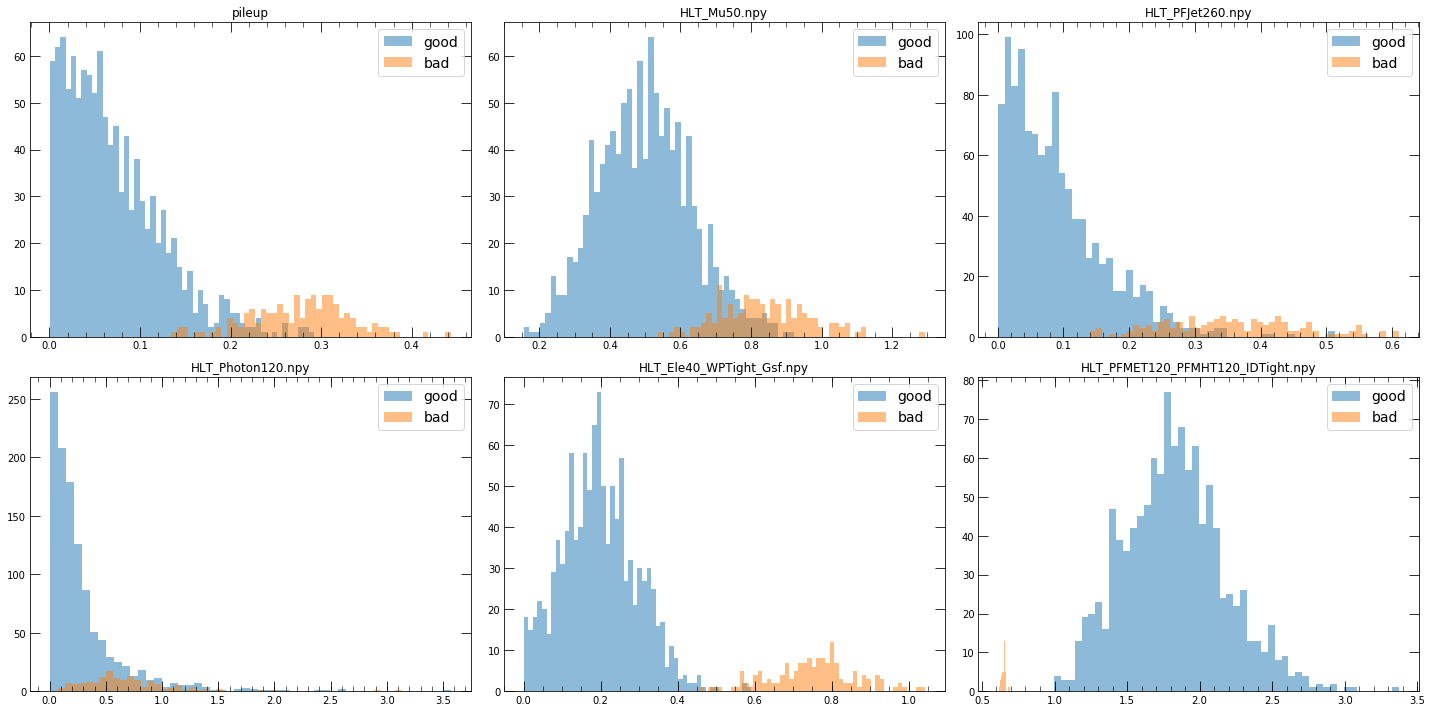

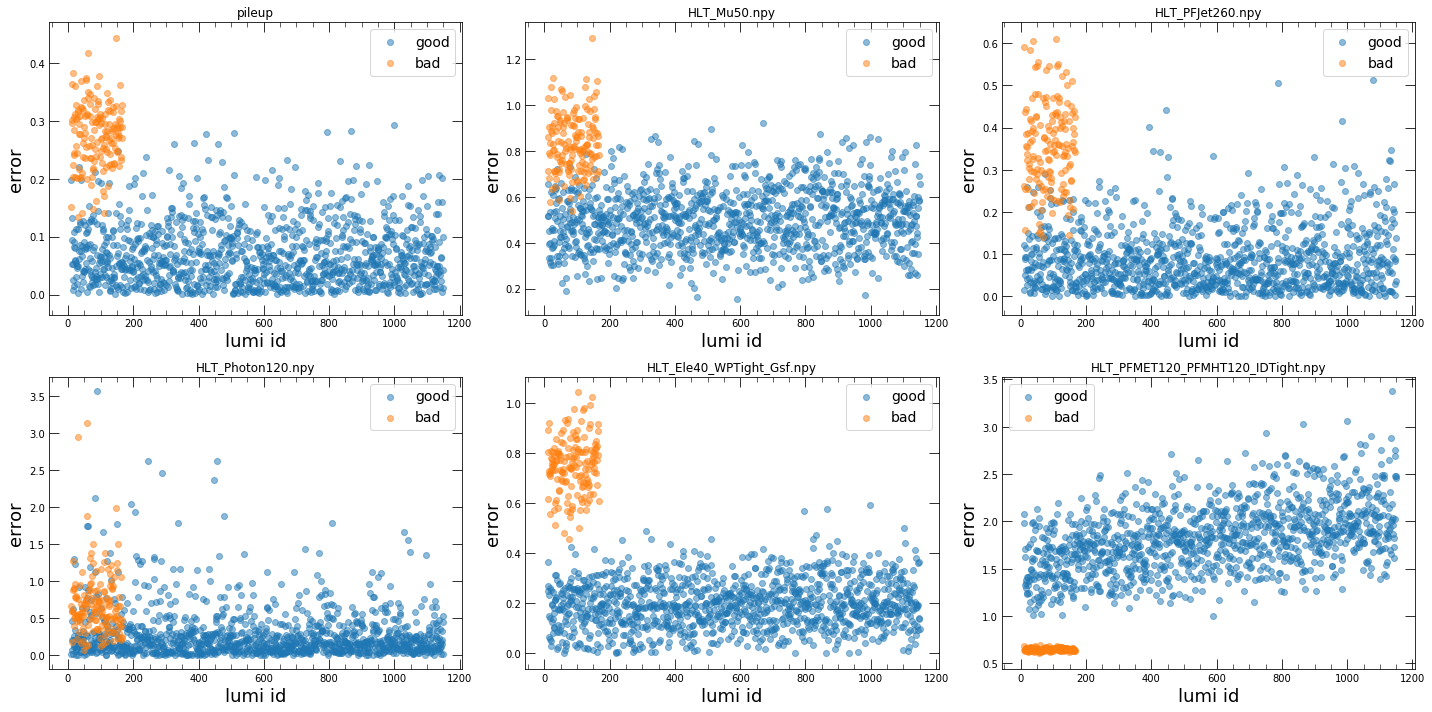

In [411]:
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
#print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

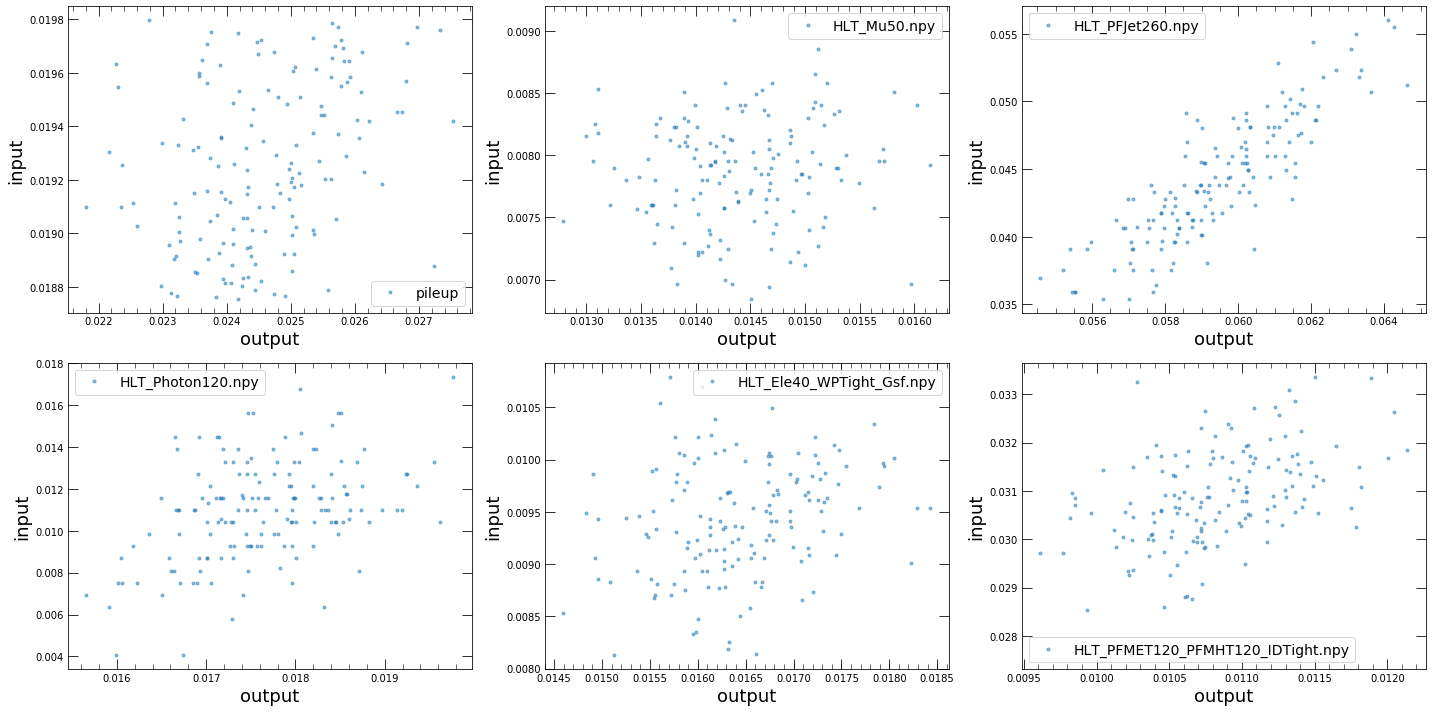

In [412]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()   

plt.tight_layout()
plt.show()

In [413]:
# Generate predictions

model = load_model("%s.h5" % (model_name))   
reconstructed = model.predict(np.array(bad_new))

means_bad = []
error_bad = []
for s in range(len(bad_new)):
    mean = np.mean(bad_new[s])
    means_bad.append(mean)
    
    mse = 0
    for r in range(len(reconstructed[s])):
        mse += (reconstructed[s][r]-mean)**2
        
    mse = mse/len(reconstructed[s])
    error_bad.append(mse)

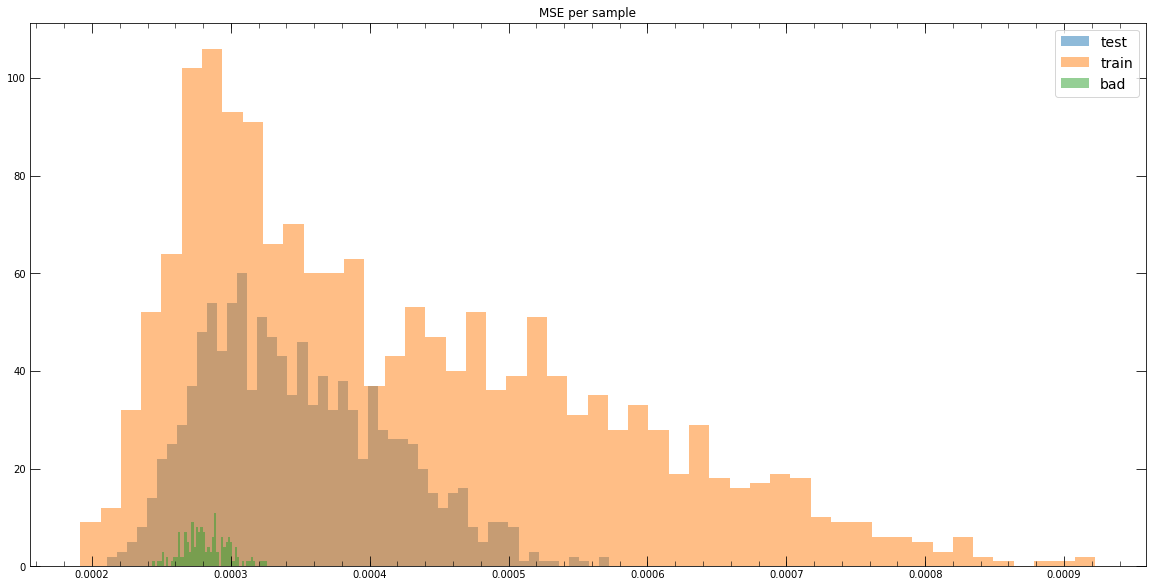

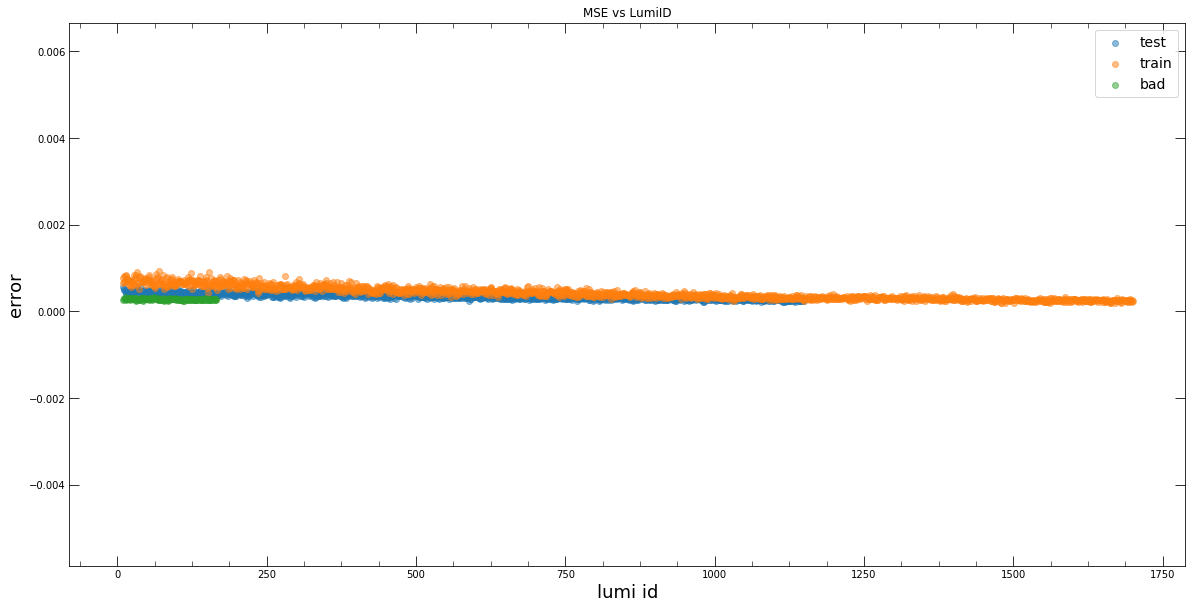

In [414]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
plt.hist(error,bins=bins,label='test',alpha=.5)
plt.hist(error_train,bins=bins,label='train',alpha=.5)
plt.hist(error_bad,bins=bins,label='bad',alpha=.5)
plt.title('MSE per sample')
plt.legend()
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
plt.scatter(lumi,error,label='test',alpha=.5)
plt.scatter(lumi_train,error_train,label='train',alpha=.5)
plt.scatter(lumiBad,error_bad,label='bad',alpha=.5)
plt.xlabel('lumi id')
plt.ylabel('error')
plt.title('MSE vs LumiID')    
plt.legend()
plt.show()

## Real Bad Data

In [415]:
bad_runs = [305588]

with open('pileupInput_bad.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [416]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        lumi_new.append(lumiBad[l])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [417]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

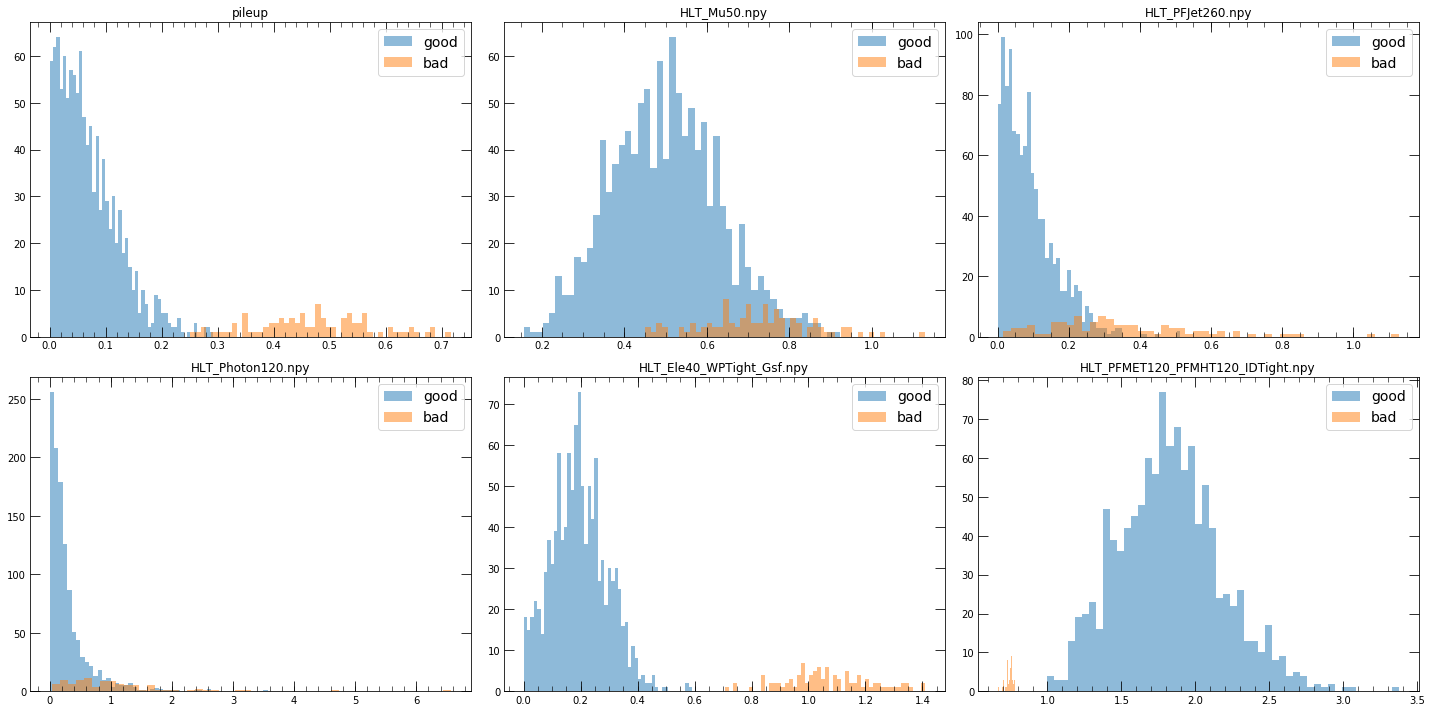

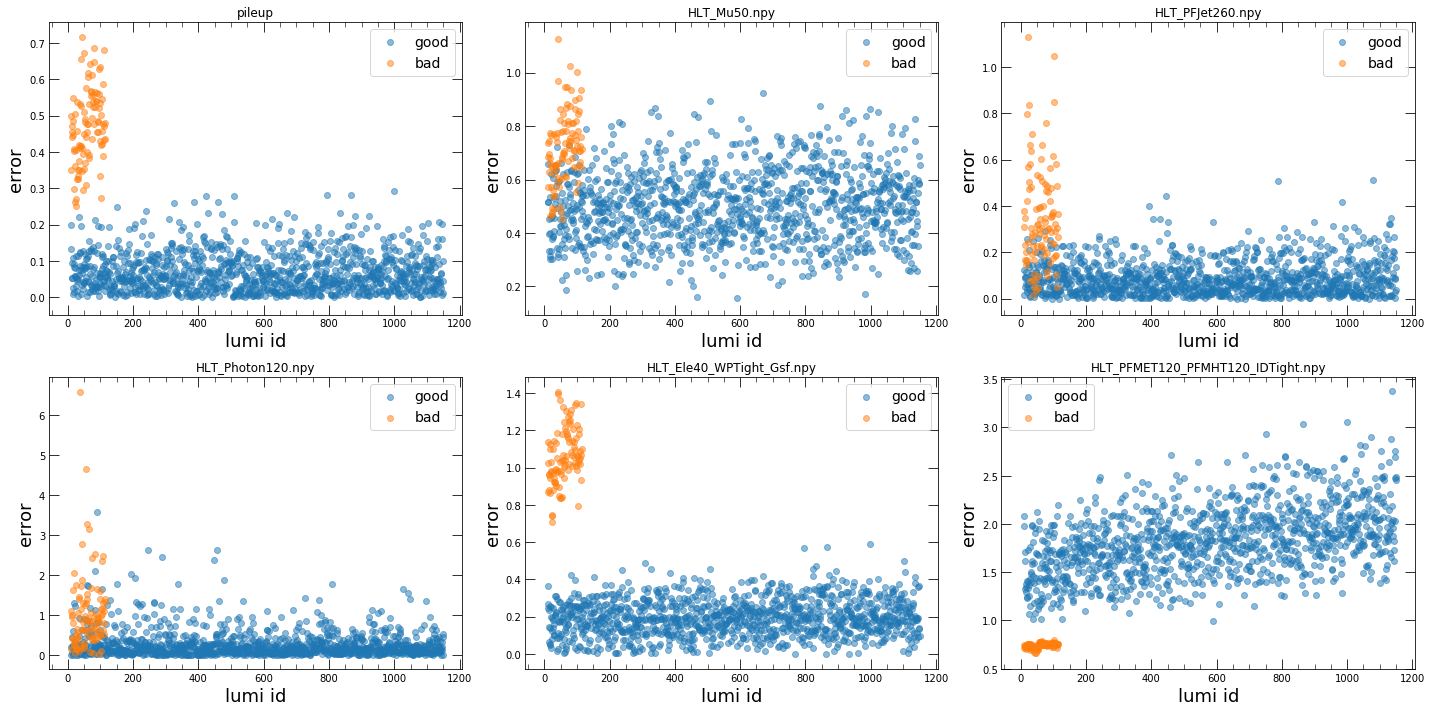

In [418]:
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
#print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

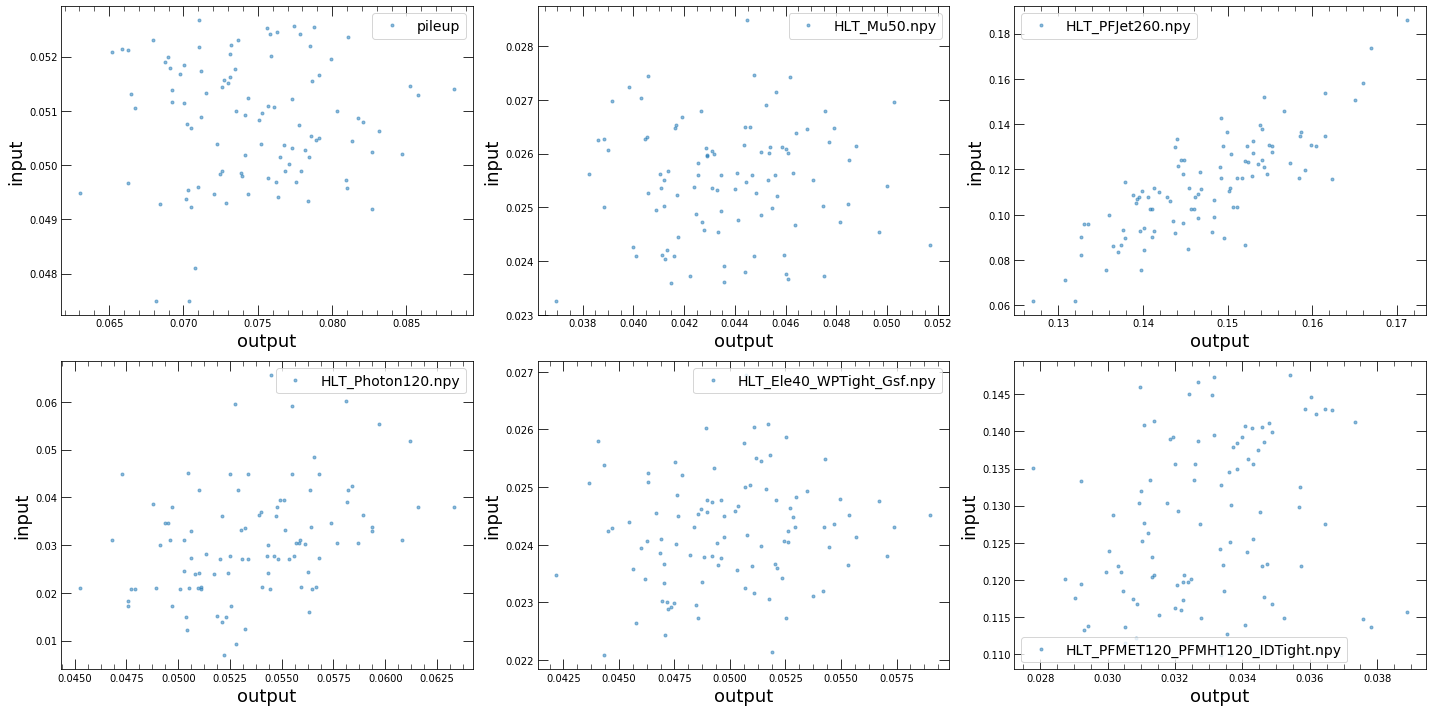

In [419]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()   

plt.tight_layout()
plt.show()

In [420]:
# Generate predictions

model = load_model("%s.h5" % (model_name))   
reconstructed = model.predict(np.array(bad_new))

means_bad = []
error_bad = []
for s in range(len(bad_new)):
    mean = np.mean(bad_new[s])
    means_bad.append(mean)
    
    mse = 0
    for r in range(len(reconstructed[s])):
        mse += (reconstructed[s][r]-mean)**2
        
    mse = mse/len(reconstructed[s])
    error_bad.append(mse)

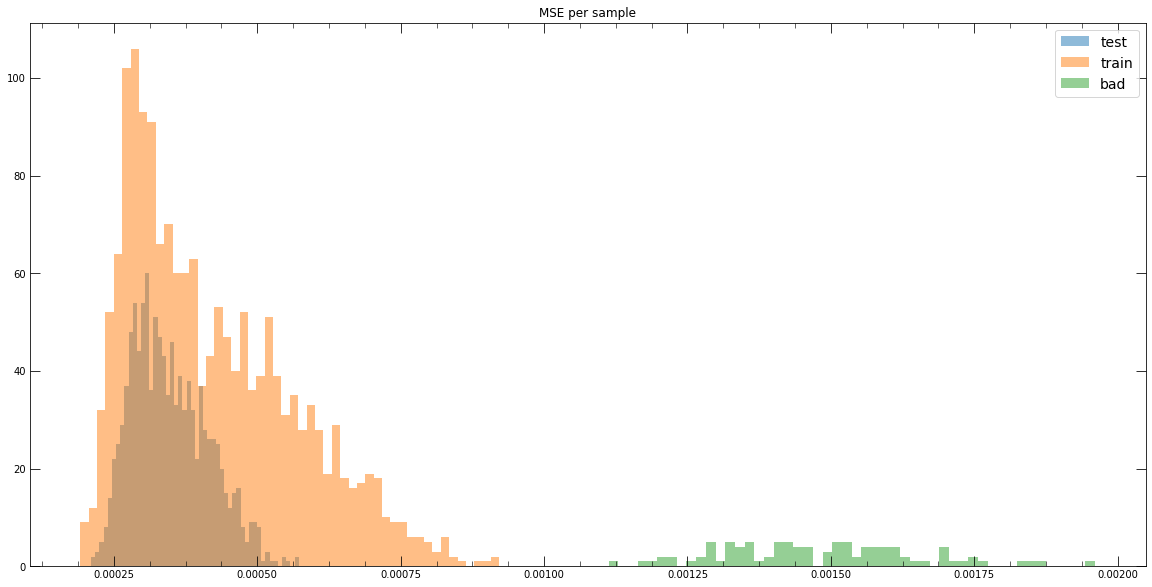

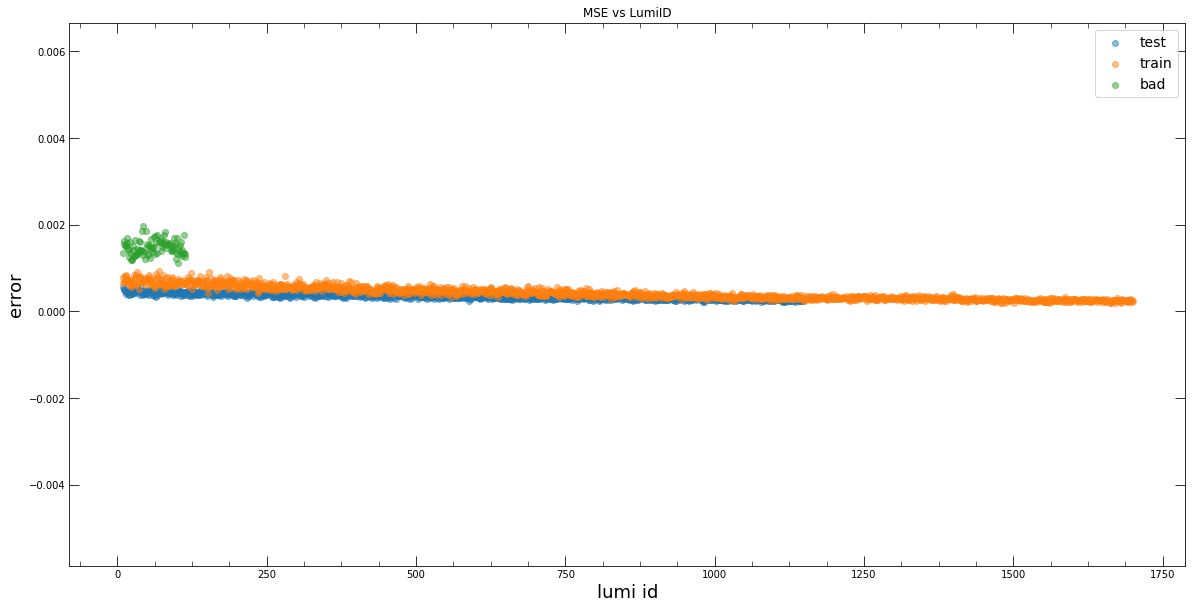

In [421]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
plt.hist(error,bins=bins,label='test',alpha=.5)
plt.hist(error_train,bins=bins,label='train',alpha=.5)
plt.hist(error_bad,bins=bins,label='bad',alpha=.5)
plt.title('MSE per sample')
plt.legend()
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
plt.scatter(lumi,error,label='test',alpha=.5)
plt.scatter(lumi_train,error_train,label='train',alpha=.5)
plt.scatter(lumiBad,error_bad,label='bad',alpha=.5)
plt.xlabel('lumi id')
plt.ylabel('error')
plt.title('MSE vs LumiID')    
plt.legend()
plt.show()

## Real Bad Data

In [422]:
bad_runs = [302566]
x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [423]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        lumi_new.append(lumiBad[l])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [424]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

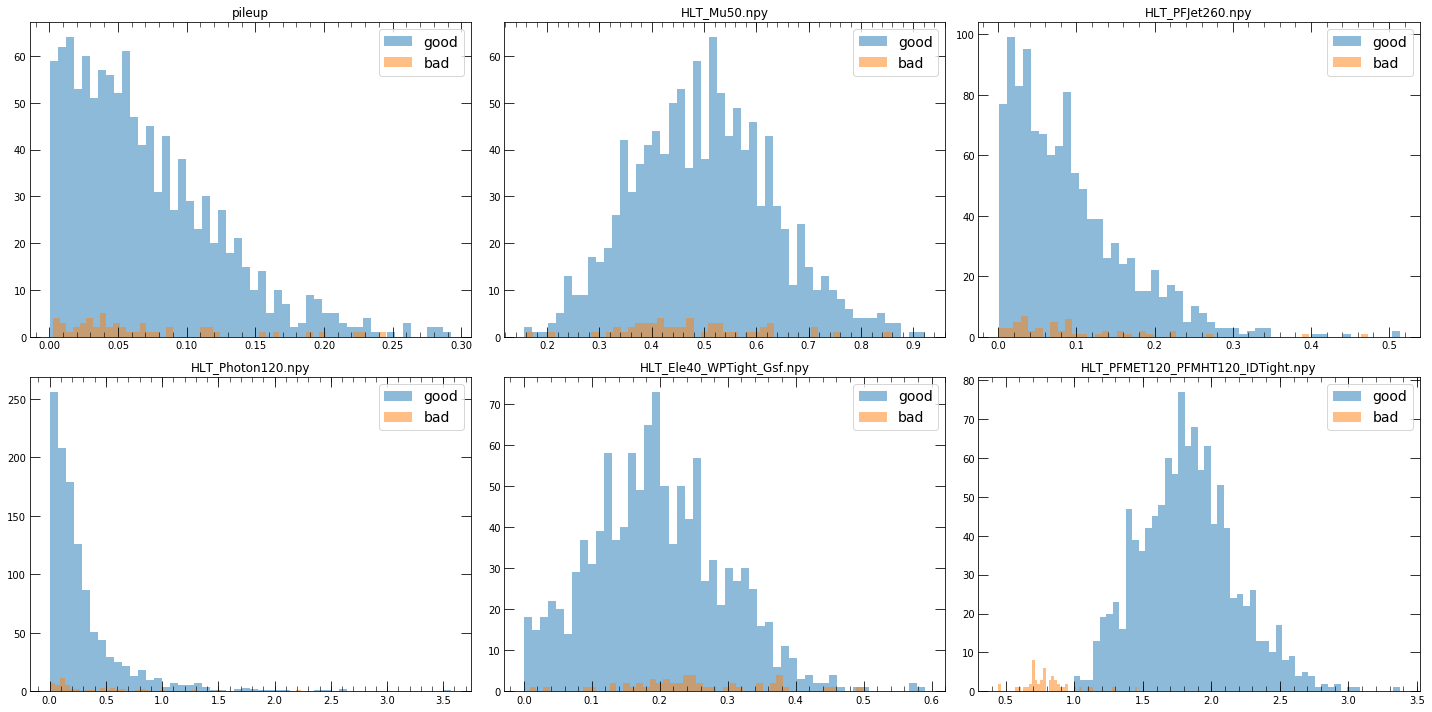

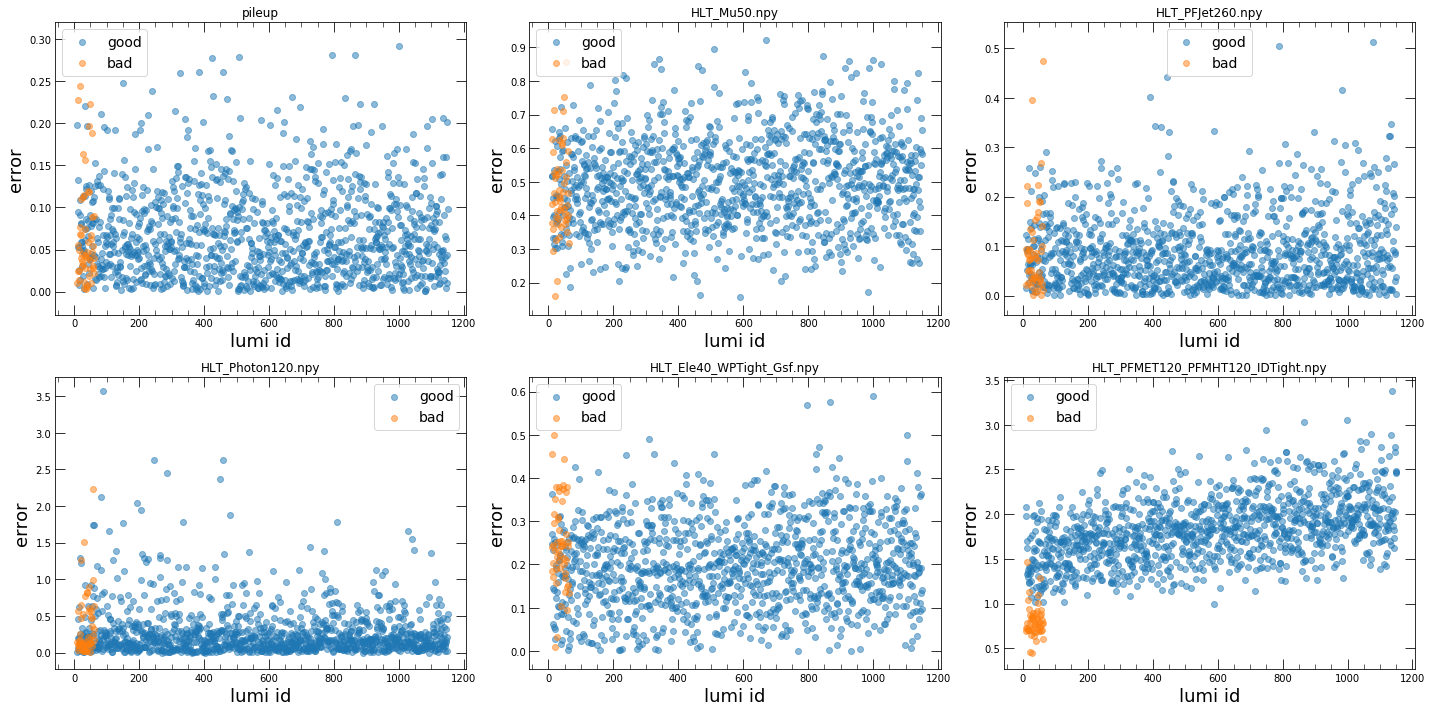

In [425]:
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()
plt.show()

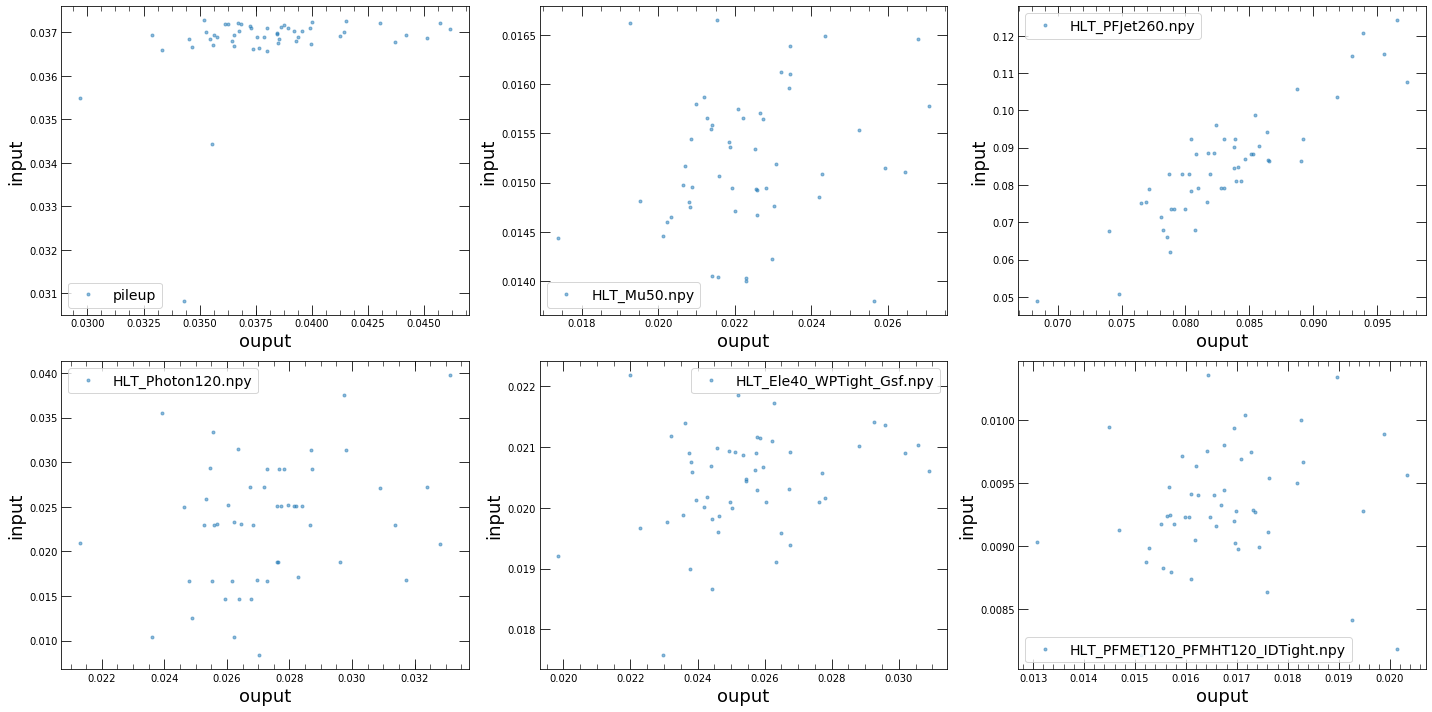

In [426]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('ouput')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    
plt.tight_layout()
plt.show()

In [427]:
# Generate predictions

model = load_model("%s.h5" % (model_name))   
reconstructed = model.predict(np.array(bad_new))

means_bad = []
error_bad = []
for s in range(len(bad_new)):
    mean = np.mean(bad_new[s])
    means_bad.append(mean)
    
    mse = 0
    for r in range(len(reconstructed[s])):
        mse += (reconstructed[s][r]-mean)**2
        
    mse = mse/len(reconstructed[s])
    error_bad.append(mse)

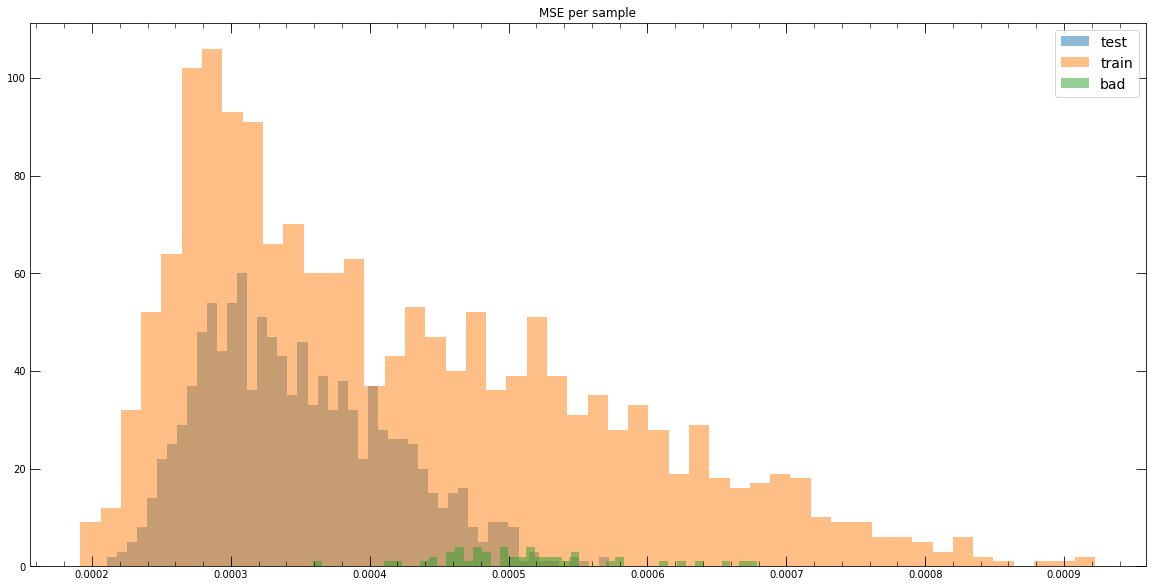

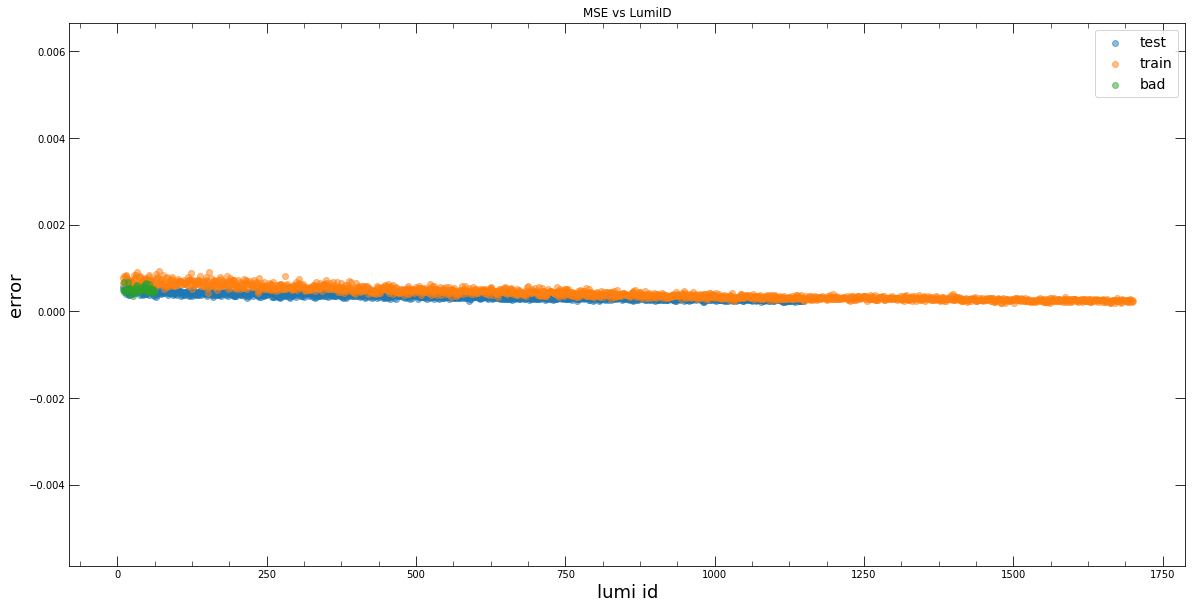

In [428]:

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
plt.hist(error,bins=bins,label='test',alpha=.5)
plt.hist(error_train,bins=bins,label='train',alpha=.5)
plt.hist(error_bad,bins=bins,label='bad',alpha=.5)
plt.title('MSE per sample')
plt.legend()
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
plt.scatter(lumi,error,label='test',alpha=.5)
plt.scatter(lumi_train,error_train,label='train',alpha=.5)
plt.scatter(lumiBad,error_bad,label='bad',alpha=.5)
plt.xlabel('lumi id')
plt.ylabel('error')
plt.title('MSE vs LumiID')    
plt.legend()
plt.show()